# <h1 align="center">ClassiFire</h1>

![WildFire Image](images/mike-newbry-_AwSiaesk40-unsplash.jpg)
### By: Keanan Ginell

# Table of Contents
<a id='top'></a>
- [Project Overview](#project-overview)
- [Business Understanding](#business-understanding)
- [Data Understanding](#data-understanding)
- [Live RAWS Dataset EDA](#live-raws-dataset-eda)
    - [Removing Duplicate NESSID Values](#Removing-Duplicate-NESSID-Values)
        - Creating df_set
- [Thiessen Polygons](#Thiessen-Polygons)
- [Loading in RAWS Stations](#Loading-in-RAWS-Stations)
- [Cleaning RAWS data](#Cleaning-RAWS-data)
- [Fire Occurrences EDA](#Fire-Occurrences-EDA)
    - [Duration](#Duration)
    - [Dropping all points outside of the contiguous USA](#Dropping-all-points-outside-of-the-contiguous-USA)
    - [Fire Incidents RAWS](#Fire-Incidents-RAWS)
    - [Fire Incident RAWS mean values](#Pulling-the-mean-values-for-each-fire)
- [Final dataset EDA](#Final-dataset-EDA)
    - [Data Checkpoint](#Data-Checkpoint)
- [Modeling](#Modeling)
    - [Model Dataset](#Model-Dataset)
    - [Modeling Class](#modeling-class)
- [Elevation](#Elevation)
- [Data Checkpoint 2](#Data-Checkpoint-2)
- [Instantiating Model Class](#model-class)
- [Random forest Model](#random-forest)
- [Decision Tree Model](#decision-tree)
- [Grid Search](#grid-search)
- [Final Model](#final-model)
- [Model Evalutation](#model-evalutation)
- [Interpreting Results](#interpreting-results)
- [Conclusion](#Conclusion)
- [Next Steps](#next-steps)
- [Repository File Structure](#repository-file-structure)


<br>

<br>
<br>

## Notes:
Use checkpoints to skip parts dataset creation, each checkpoint contains hyperlink to prvious cells that need to be run, run imports before continuing 
<details>
<summary>Quick Links</summary>

##### Corresponding Features Analysis and Data Completion:
        - replace nulls and drop corresponding feature
- [Acres size of fire](#similar-feature-acres)
- [Time when Fire went out](#similar-feature-fireout-time)
- [cost of fire](#similar-feature-cost)
- [Dispatch Center](#similar-feature-dispatch-center)
    
</details>

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 35)
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import time
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor                         
from sklearn.metrics import plot_confusion_matrix, classification_report, log_loss, confusion_matrix,\
                            plot_roc_curve, precision_score, recall_score, accuracy_score, f1_score,\
                            roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from datetime import datetime, timedelta
from joblib import Parallel, delayed
import requests
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter

<a id='general-overview'></a>
# Project Overview
---

The goal of this project is to develop a classification model that can predict the fire management complexity level of a wildfire. Fire management complexity represents the highest management level utilized to manage a wildland fire. This target provides valuable insights into the resources needed and the potential scale, size and impact of a fire.

This classification model analyzes various features associated with the a wildfire incident, including meteorological data, bureaucratic data, and locational data. The developed classification model will enable fire management agencies to anticipate the resources required should a wildfire occur based on the location and current meteorological data. This model doesn't replace the realtime complex decision of determining fire management complexity level (like evaluating the risk to the firefighters). However this model can aid in helping predict if a new wildfire incident will be a large scale/impacting event based on the predicted fire management complexity.



<a id='business-understanding'></a>
# Business Understanding
---

Wildfires pose a significant risks to life, property, and the environment. Effective fire management is crucial for mitigating these risks and minimizing the impact of wildfires. Predicted fire management complexity level evaluates if a location is at risk of being resource intensive or potentially large threat to life and property should a wildfire occur. This can help identify regions that need to be on high alert and preparedness to minimize the impact of a wildfire.

The fire agencies administrator is responsible for setting the fire managment complexity level. Their decision follows a set of standarized and subjective guidelines. Some of these guidelines are utilized as features in this project.

Fire management agencies, administrators, and other personnel responsible for allocating resources and planning fire response strategies would benefit from being able to accurately and efficiently predict the fire management complexity level of wildland fire incidents. This allows for them to anticipate the required resources, as well as assess the potential scale and impact of a fire. This information is crucial for fire management agencies to make informed decisions and ensured preparedness for faster fire response times.




<a id='data-understanding'></a>
# Data Understanding

  - [Target](#Target)
  - [Data Sources](#data-sources)
  - [Data Directory](#data-directory)
  - [Key Features](#key-features)
## Target
  - FireMgmtComplexity (Defined [here](#key-features))
#### Factors contributing to the fire management complexity level:
  - Area involved
  - Threat to life and property
  - Political sensitivity
  - Organizational complexity
  - Jurisdictional boundaries
  - Values at risk
  - Fire behavior
  - Strategy and tactics
  - Agency policy

Source: https://gacc.nifc.gov/swcc/management_admin/Agency_Administrator/AA_Guidelines/pdf_files/ch5.pdf
#### FireMgmtComplexity Classes:
The levels of wildfire fire incidents range from Type 5 to Type 1. Each level represents a specific level of complexity
- Type 5:
  - lowest class
  - local resources 
  - 2-6 firefighters
  - quickly contained
  - low impact risk
- Type 4
  - Local resources
  - low impact risk
  - slight increase in scale compared to Type 5
- Type 3
  - Mix of local and regional resources used
  - increased scale and risk
  - action plan created
- Type 2
  - large scale 200+ firefighters
  - Many units required
  - regular planning and briefing
- Type 1 
  - highest class
  - Same characteristics of type 2 incident
  - 500+ firefighters
  - aircraft and aviation is used
  - Greater access to resources
  - larger scale and impact 
## Data Sources
The data used in this project comes from the following sources below:
- Wildfire Occurrences
  - https://data-nifc.opendata.arcgis.com/datasets/nifc::wildland-fire-incident-locations/about
  - This dataset gets updated daily and contains data going back to roughly 2014
- Live RAWS Data (Remote Access Weather Stations)
  - https://data-nifc.opendata.arcgis.com/datasets/nifc::public-view-interagency-remote-automatic-weather-stations-raws/about
  - Dataset of live RAWS data
- Historical RAWS Data
  - https://raws.dri.edu/
  - Contains historical data for around 3k RAWS 
- Elevation data:
  - open elevation api 
## Data Directory 
| Data | Curation | Utilization | Additional Info |
|----------|----------|----------|----------------|
| station_list.csv    | web_scraper.ipynb    | post_request.ipynb    | RAWS 4-digit code |
| threshold_year.pickle    | web_scraper.ipynb   | EDA1.ipynb    | RAWS code and final year station collected data|
| nessid.csv    | web_scraper.ipynb    | EDA1.ipynb    | NESSID and RAWS code|
| RAWS_Historical_Full    | post_request.ipynb   | EDA1.ipynb    |Json files split into 4 files|
| RAWS.csv    | Live RAWS download    | Modeling.ipynb    ||
| stations_dates.csv.zip    | EDA1.ipynb    | Modeling.ipynb    | Row corresponds to a day, column represents a RAWS. Missing data for a RAWS on a specific day is denoted as null.|
| RAWS_stations.csv.zip    | EDA1.ipynb    | Modeling.ipynb    |This is split up into 1,2 and 3, Use pd.concat([1,2,3], axis=1) in notebook|
| Wildland_Fire_Incident_Locations.csv.zip    | Wildfire Occurrences download    | Modeling.ipynb   ||
| clean_fire_data.csv.zip  | Modeling.ipynb   | Modeling.ipynb   ||
| fire_elevation.csv  | Modeling.ipynb   | Modeling.ipynb   |Elevation of each fire incident|
| fire_model_data.csv  | Modeling.ipynb   | Modeling.ipynb   |Final dataset used to Model, drop unwanted column before modeling|


## Key Features
Below are the key features used in this project. Several features in the dataset have corresponding features that contained the same or similar data. These features were utilized to fill in missing values whenever possible. There are many more features then what is listed here, refer to source websites for an indepth overview.
### Fire Incidents:
Definitions provided by source
- **FireMgmtComplexity:** The highest management level utilized to manage a wildland fire

- **FinalAcres:** Final burn acres, nulls filled in with IncidentSize
- **site:** Created in Modeling.ipynb, closest RAWS that has at least 50% data coverage over the duration of a fire incident. 
  -  It is used as a reference point for analyzing weather conditions during the fire event.
-  **DispatchCenterID:** A unique identifier for a dispatch center responsible for supporting the incident. Nulls filled in with POODispatchCenterID
-  **POODispatchCenterID:** A unique identifier for the dispatch center that intersects with the incident point of origin (point where fire incident occured)
- **POOJurisdictionalAgency:** The agency having land and resource management responsibility for a fire incident as provided by federal, state or local law
- **POOFips:** Code identifies counties and county equivalents. The first two digits are the FIPS State code and the last three are the county code within the state.
- **FireDiscoveryDateTime:** The date and time a fire was reported as discovered or confirmed to exist
- **FireOutDateTime:** The date and time when a fire is declared out
- **OBJECTID:** Incident ID for dataset
- **EstimatedFinalCost:** Nulls filled in with EstimatedCostTodate
- **elevation:** Elevation of fire incident (meters) 
### RAWS data:
For each fire incident, all meteorological metrics were computed as averages of the fire duration.
  - **NESSID:**  NESS ID for identifying RAWS
  
  - **X:** Longitude
  - **Y:** Latitude
  - **date:** date when data was collected, if null then no data collected on that day
  - **total_solar_radiation_ly:** Solar radiation
  - **ave_mean_wind_speed_mph:** Average wind speed (mph)
  - **ave_mean_wind_direction_deg:** Average wind direction (degree)
  - **max_maximum_wind_gust_mph:** Maximum wind gust (mph)
  - **ave_average_air_temperature_deg_f:** Average air temperature (ºF)
  - **ave_average_relative_humidity:** Average relative humidity
  - **total_precipitation_in:** Total precipitation (inches)
  
  Data Set length: over 250K and the final model dataset has a length of 7731
  RAWS: There are roughly 2252 RAWS sites with usable data, aaround 3k in total

<a id='live-raws-dataset-eda'></a>
# Live RAWS Dataset EDA
- Completed prior to webscraping
- What stations have nulls?
- What ID should be used, NESSID, WXID, NWSID, Station ID?

In [655]:
# Importing live IRAWS Stations data
df1 = pd.read_csv('Data/RAWS.csv')

# There are duplicates but Object Id column prevents .duplicated() from running correctly so i drop this column
df1.drop(columns='OBJECTID', inplace=True)

# several rows contain a NO DATA value, here i replace those with nulls
df1.replace("NO DATA", np.nan, inplace=True)

In [656]:
df1['NESSID'].value_counts()

325515EE    15
32416F08    14
326F772A    12
328B27E6    10
FF1041BA     9
            ..
3266B468     1
326DE7BC     1
326116A4     1
0800C6DC     1
D680125A     1
Name: NESSID, Length: 2495, dtype: int64

In [657]:
def unique_stations(df):
    # Find column with the most letters, return the length
    column_width = max(len(column) for column in df.columns)
    # header, sets space to fit the longest column name
    print(f"\033[1m{'Columns':<{column_width}} | {'Length':<15} | Nulls \033[0m")
    print(f"{'':<{column_width +1}}|\033[31m (Unique Values) \033[0m|")
    print(f"{'-'*40}")
    
    # Columns length
    for column in df.columns:
        length = len(df[column].value_counts())
        print(f"{column:<{column_width}} | {length:<15} | {df[column].isna().sum()}")
unique_stations(df1)

Columns           | Length          | Nulls 
                  | (Unique Values) |
----------------------------------------
X                 | 2916            | 7
Y                 | 2912            | 7
StationName       | 2708            | 0
WXID              | 6487            | 570
ObservedDate      | 3737            | 0
NESSID            | 2495            | 570
NWSID             | 2026            | 1742
Elevation         | 2036            | 580
SiteDescription   | 1775            | 3448
Latitude          | 2705            | 570
Longitude         | 2707            | 570
State             | 53              | 570
County            | 723             | 967
Agency            | 10              | 570
Region            | 89              | 621
Unit              | 486             | 855
SubUnit           | 822             | 2797
Status            | 4               | 570
RainAccumulation  | 2787            | 59
WindSpeedMPH      | 90              | 75
WindDirDegrees    | 377             | 1911


In [658]:
# This project doesn't use IRAWS stationos as they do not have a NESSID Column,
# they can be added but more data will need pulled through post requests
df1[df1['StationName']== 'IRAWS 3']

,X,Y,StationName,WXID,ObservedDate,NESSID,NWSID,Elevation,SiteDescription,Latitude,Longitude,State,County,Agency,Region,Unit,SubUnit,Status,RainAccumulation,WindSpeedMPH,WindDirDegrees,AirTempStandPlace,FuelTemp,RelativeHumidity,BatteryVoltage,FuelMoisture,WindDirPeak,WindSpeedPeak,SolarRadiation,StationID
51,-123.10313,41.24443,IRAWS 3,NaN,2022/02/16 12:45:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06 inches,0 mph,NaN,31 deg. F,NaN,83 %,NaN,NaN,NaN,NaN,NaN,18038699
3935,-116.20833,43.56500,IRAWS 3,NaN,2022/05/03 18:14:59+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,14 mph,NaN,61 deg. F,NaN,19 %,NaN,NaN,NaN,NaN,NaN,18038705
6136,-116.20833,43.56500,IRAWS 3,NaN,2023/02/02 14:45:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,0 mph,NaN,17 deg. F,NaN,77 %,NaN,NaN,NaN,NaN,NaN,18038717
6174,-116.20833,43.56500,IRAWS 3,NaN,2023/02/02 21:30:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,1 mph,NaN,40 deg. F,NaN,41 %,NaN,NaN,NaN,NaN,NaN,18038719


In [659]:
# Data Frame containning rows where NESSID is null.
# Checking the NESSID column for nulls
# This indicates that for rows missing NESSID, they have key information thats useful, 
# Evalute further before dropping
print(df1[df1['NESSID'].isna() == True].info())
df1[df1['NESSID'].isna() == True]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 570 entries, 51 to 7072
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  568 non-null    float64
 1   Y                  568 non-null    float64
 2   StationName        570 non-null    object 
 3   WXID               0 non-null      float64
 4   ObservedDate       570 non-null    object 
 5   NESSID             0 non-null      object 
 6   NWSID              0 non-null      object 
 7   Elevation          0 non-null      float64
 8   SiteDescription    0 non-null      object 
 9   Latitude           0 non-null      float64
 10  Longitude          0 non-null      float64
 11  State              0 non-null      object 
 12  County             0 non-null      object 
 13  Agency             0 non-null      object 
 14  Region             0 non-null      object 
 15  Unit               0 non-null      object 
 16  SubUnit            0 non

,X,Y,StationName,WXID,ObservedDate,NESSID,NWSID,Elevation,SiteDescription,Latitude,Longitude,State,County,Agency,Region,Unit,SubUnit,Status,RainAccumulation,WindSpeedMPH,WindDirDegrees,AirTempStandPlace,FuelTemp,RelativeHumidity,BatteryVoltage,FuelMoisture,WindDirPeak,WindSpeedPeak,SolarRadiation,StationID
51,-123.10313,41.24443,IRAWS 3,NaN,2022/02/16 12:45:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06 inches,0 mph,NaN,31 deg. F,NaN,83 %,NaN,NaN,NaN,NaN,NaN,18038699
63,-109.98161,31.87208,RO PORTABLE #4,NaN,2022/04/03 16:28:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12 inches,6 mph,NaN,64 deg. F,NaN,22 %,NaN,NaN,NaN,NaN,NaN,17869349
72,-80.49248,36.35649,PILOT MOUNTAIN,NaN,2022/03/15 13:02:59+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.19 inches,0 mph,NaN,23 deg. F,NaN,98 %,NaN,NaN,NaN,NaN,NaN,17920804
97,-105.05300,35.82131,IRAWS 1 (RIO MORA),NaN,2022/05/11 06:45:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,2 mph,NaN,55 deg. F,NaN,16 %,NaN,NaN,NaN,NaN,NaN,17989326
162,-114.73650,48.41300,SWANEY,NaN,2022/12/05 14:39:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.72 inches,0 mph,NaN,12 deg. F,NaN,88 %,NaN,NaN,NaN,NaN,NaN,17797660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7054,-107.48400,37.30422,SAN JUAN PORTABLE #2,NaN,2023/05/05 09:46:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,0 mph,NaN,33 deg. F,NaN,55 %,NaN,NaN,NaN,NaN,NaN,19451418
7061,-109.57233,43.43539,SHF5 PORTABLE,NaN,2023/05/05 10:08:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01 inches,5 mph,NaN,36 deg. F,NaN,75 %,NaN,NaN,NaN,NaN,NaN,19389973
7063,-116.20833,43.56500,PRAWS 4,NaN,2023/05/05 10:20:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,2 mph,NaN,50 deg. F,NaN,75 %,NaN,NaN,NaN,NaN,NaN,18899301
7068,-114.58861,46.78111,LOLO PORTABLE #6,NaN,2023/05/04 17:13:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1 inches,2 mph,NaN,0 deg. F,NaN,40 %,NaN,NaN,NaN,NaN,NaN,19873805


In [660]:
# Majority of the IRAWS have nulls for the NESSID stations
df2 = df1[df1['NESSID'].isna() == True]
print(f"Number of IRAWS stations total: {len(df1[df1['StationName'].str.contains('IRAWS')])}")
print(f"Number of PRAWS stations total: {len(df1[df1['StationName'].str.contains('PRAWS')])}")
print(f"Of the {len(df1[df1['StationName'].str.contains('IRAWS')])} IRAWS stations, \
{len(df2[df2['StationName'].str.contains('IRAWS')])} Contain no NESSID")

df2[df2['StationName'].str.contains('IRAWS')]


Number of IRAWS stations total: 238
Number of PRAWS stations total: 75
Of the 238 IRAWS stations, 196 Contain no NESSID


,X,Y,StationName,WXID,ObservedDate,NESSID,NWSID,Elevation,SiteDescription,Latitude,Longitude,State,County,Agency,Region,Unit,SubUnit,Status,RainAccumulation,WindSpeedMPH,WindDirDegrees,AirTempStandPlace,FuelTemp,RelativeHumidity,BatteryVoltage,FuelMoisture,WindDirPeak,WindSpeedPeak,SolarRadiation,StationID
51,-123.10313,41.24443,IRAWS 3,NaN,2022/02/16 12:45:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06 inches,0 mph,NaN,31 deg. F,NaN,83 %,NaN,NaN,NaN,NaN,NaN,18038699
97,-105.05300,35.82131,IRAWS 1 (RIO MORA),NaN,2022/05/11 06:45:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,2 mph,NaN,55 deg. F,NaN,16 %,NaN,NaN,NaN,NaN,NaN,17989326
188,-116.20861,43.55972,IRAWS 39,NaN,2022/03/15 18:03:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,0 mph,NaN,47 deg. F,NaN,78 %,NaN,NaN,NaN,NaN,NaN,17994848
292,-112.32306,45.99556,IRAWS 36,NaN,2022/03/02 15:33:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,1 mph,NaN,45 deg. F,NaN,70 %,NaN,NaN,NaN,NaN,NaN,17994100
329,-104.93564,36.34879,IRAWS 7 (DP90),NaN,2022/05/03 19:46:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,15 mph,NaN,73 deg. F,NaN,17 %,NaN,NaN,NaN,NaN,NaN,18039187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6978,-116.20833,43.56500,IRAWS 44,NaN,2023/04/27 12:19:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,3 mph,NaN,48 deg. F,NaN,58 %,NaN,NaN,NaN,NaN,NaN,17996162
6980,-116.20833,43.56500,IRAWS 42,NaN,2023/04/27 12:19:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,3 mph,NaN,48 deg. F,NaN,58 %,NaN,NaN,NaN,NaN,NaN,17995653
7001,-116.20833,43.56500,IRAWS 54,NaN,2023/05/01 11:19:59+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,6 mph,NaN,65 deg. F,NaN,38 %,NaN,NaN,NaN,NaN,NaN,19042621
7023,-116.20833,43.56500,IRAWS 52,NaN,2023/05/03 15:19:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 inches,0 mph,NaN,66 deg. F,NaN,29 %,NaN,NaN,NaN,NaN,NaN,19042133


After looking at documentation NWS ID represents
(WIMS Station ID) Unique six-digit identification number assigned to the weather station.


Upon further evaluation there are roughly 1700 nulls for this while NESSID only has around 570


In [661]:
# Checking duplicates
df1.duplicated().sum()

18

In [662]:
def duplicates(df, output=None):# locating duplicate
    '''
    Located number of duplicates
    set output= any value to display the non-duplicated
    '''
    print(f'Number of Duplicates: {df.duplicated().sum()}')
    if output:
        display(df.loc[df.duplicated() == False])      
    else:
        display(df.loc[df.duplicated() == True])
duplicates(df1)

Number of Duplicates: 18


,X,Y,StationName,WXID,ObservedDate,NESSID,NWSID,Elevation,SiteDescription,Latitude,Longitude,State,County,Agency,Region,Unit,SubUnit,Status,RainAccumulation,WindSpeedMPH,WindDirDegrees,AirTempStandPlace,FuelTemp,RelativeHumidity,BatteryVoltage,FuelMoisture,WindDirPeak,WindSpeedPeak,SolarRadiation,StationID
4881,-105.57236,40.79281,REDFEATHER,16927282.0,2022/11/16 16:33:00+00,323610D2,050505,8233.0,NaN,40.79281,-105.57236,CO,Larimer,USFS,02,ARAPAHO/ROOSEVELT NF,REDFEATHER,A,11.18 inches,9 mph,331 degrees,26 deg. F,33 deg. F,45 %,15.1 volts,9.5 (unk),312 degrees,20 mph,279 w/m2,16927282
4882,-95.09472,30.51806,COLDSPRINGS,17294878.0,2023/04/24 18:03:00+00,3288B58A,414201,145.0,NaN,30.51806,-95.09472,TX,San Jacinto,USFS,08,NF'S IN TEXAS,SAM HOUSTON NF,A,60.64 inches,3 mph,45 degrees,67 deg. F,79 deg. F,58 %,13.4 volts,10.7 (unk),20 degrees,9 mph,447 w/m2,17294878
4883,-105.22694,40.57083,REDSTONE,17066030.0,2023/05/05 09:57:00+00,3335E6FA,050508,6160.0,FIRE WX ZONE: 215,40.57083,-105.22694,CO,Larimer,USFS,02,ARAPAHO/ROOSEVELT NF,POUDRE FIRE AUTHORIT,A,3.83 inches,2 mph,340 degrees,43 deg. F,NaN,83 %,12.8 volts,NaN,1 degrees,4 mph,0 w/m2,17066030
4884,-74.31611,40.09861,JACKSON,17392930.0,2022/10/25 21:11:00+00,FF1041BA,280291,105.0,NaN,40.09861,-74.31611,NJ,Ocean,S&PF,NEW JERSEY,FOREST FIRE SERVICE,NaN,A,36.91 inches,2 mph,147 degrees,73 deg. F,73 deg. F,82 %,13.4 volts,23.3 (unk),155 degrees,8 mph,137 w/m2,17392930
4885,-74.49417,40.40722,NEW MIDDLESEX COUNTY,17392680.0,2022/12/27 15:11:00+00,FF10372A,280231,94.0,NaN,40.40722,-74.49417,NJ,Middlesex,S&PF,NEW JERSEY,FOREST FIRE SERVICE,NaN,A,42.89 inches,5 mph,267 degrees,31 deg. F,33 deg. F,51 %,13.9 volts,11 (unk),289 degrees,11 mph,135 w/m2,17392680
4886,-119.06140,37.66182,INF05 PORTABLE,17407304.0,2022/11/01 01:12:59+00,32878682,NaN,9300.0,NaN,37.66182,-119.06140,CA,Mono,USFS,05,INYO NF,Mono RD,A,.04 inches,5 mph,233 degrees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407304
4887,-123.89645,40.64000,CALFIRE PORTABLE 12,17226578.0,2023/04/24 19:25:00+00,CA49643C,NaN,2495.0,NaN,40.64000,-123.89645,CA,Humboldt,S&PF,CALIFORNIA,CDF,HUMBOLDT-DEL NORTE U,A,.02 inches,3 mph,294 degrees,58 deg. F,64 deg. F,64 %,13.4 volts,13.1 (unk),327 degrees,11 mph,402 w/m2,17226578
4888,-114.38161,45.75567,BITTERROOT QD#1 - PORT,17129304.0,2022/10/17 20:18:00+00,326D044E,241598,5987.0,Placed along side gated road within a stand of...,45.75567,-114.38161,MT,Ravalli,USFS,01,BITTERROOT NF,BITTERROOT NF,A,0 inches,3 mph,159 degrees,81 deg. F,87 deg. F,10 %,12.2 volts,6.7 (unk),183 degrees,5 mph,683 w/m2,17129304
4889,-112.00758,38.65989,FISHLAKE D4 PT #4,18048571.0,2022/11/01 18:01:59+00,32D3D786,NaN,9809.0,NaN,38.65989,-112.00758,UT,Sevier,USFS,04,FISHLAKE NF,RICHFIELD DISTRICT 4,A,0.71 inches,12 mph,NaN,38 deg. F,NaN,36 %,NaN,NaN,NaN,NaN,NaN,18048571
4890,-105.57236,40.79281,REDFEATHER,16927282.0,2022/11/16 16:33:00+00,323610D2,050505,8233.0,NaN,40.79281,-105.57236,CO,Larimer,USFS,02,ARAPAHO/ROOSEVELT NF,REDFEATHER,A,11.18 inches,9 mph,331 degrees,26 deg. F,33 deg. F,45 %,15.1 volts,9.5 (unk),312 degrees,20 mph,279 w/m2,16927282


### Checking if all station names are in all caps or not
- only 2 are not in all caps, these don't have a id and will likley end up not being a match anyways

In [663]:
# Checking the capitalization of station names
df1['StationName'].str.isupper().value_counts()

True     7073
False       2
Name: StationName, dtype: int64

In [664]:
df1[~df1['StationName'].str.isupper()]

,X,Y,StationName,WXID,ObservedDate,NESSID,NWSID,Elevation,SiteDescription,Latitude,Longitude,State,County,Agency,Region,Unit,SubUnit,Status,RainAccumulation,WindSpeedMPH,WindDirDegrees,AirTempStandPlace,FuelTemp,RelativeHumidity,BatteryVoltage,FuelMoisture,WindDirPeak,WindSpeedPeak,SolarRadiation,StationID
287,-80.97806,26.30472,FLSEA_Port1,NaN,2022/03/15 13:05:59+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.86 inches,4 mph,NaN,73 deg. F,NaN,87 %,NaN,NaN,NaN,NaN,NaN,17633816
3549,-116.20806,43.59944,Depot Test 210,NaN,2022/03/15 13:25:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.72 inches,1 mph,NaN,46 deg. F,NaN,70 %,NaN,NaN,NaN,NaN,NaN,17823340


In [665]:
def contains(dfs, column, string, upc=False):
    '''
    Function searchs input column for the input string or numeric
    df: input dataframe
    column : column to search for string
    string : Words to search for, if a int or float, inupt numbers
    upc : False, if True will apply all caps to input string and search for only all caps
    
    if integer or float, it will need the full value not just part of it
     Strings use .contains, while numbers use a .loc == int
    '''
    df = dfs.copy()
    df.dropna(subset=[column], inplace=True)
    try: 
        if upc:
            print('Searching for Uppercase strings')
            display(df[df[column].str.contains(string.upper())])
        else:
            display(df[df[column].str.contains(string, case=False)])
    except Exception as e:
        print(f'ERROR: {e}')
        display(df[df[column]== string])       

In [666]:
contains(df1, 'StationName', 'holli')

,X,Y,StationName,WXID,ObservedDate,NESSID,NWSID,Elevation,SiteDescription,Latitude,Longitude,State,County,Agency,Region,Unit,SubUnit,Status,RainAccumulation,WindSpeedMPH,WindDirDegrees,AirTempStandPlace,FuelTemp,RelativeHumidity,BatteryVoltage,FuelMoisture,WindDirPeak,WindSpeedPeak,SolarRadiation,StationID
395,-121.36216,36.8422,HOLLISTER,17375525.0,2023/03/22 19:12:59+00,CA25B1FA,044406,404.0,Located on the southeast corner of the Hollist...,36.8422,-121.36216,CA,San Benito,S&PF,CALIFORNIA,CDF,SAN BENITO/MONT UNIT,A,16.46 inches,9 mph,156 degrees,54 deg. F,54 deg. F,76 %,14 volts,24 (unk),163 degrees,18 mph,326 w/m2,17375525
3984,-121.36216,36.8422,HOLLISTER,17375524.0,2022/03/15 13:12:59+00,CA25B1FA,044406,404.0,Located on the southeast corner of the Hollist...,36.8422,-121.36216,CA,San Benito,S&PF,CALIFORNIA,CDF,SAN BENITO/MONT UNIT,1,7.65 inches,1 mph,295 degrees,49 deg. F,49 deg. F,66 %,13 volts,8.3 (unk),80 degrees,5 mph,0 w/m2,17375524
6546,-121.36216,36.8422,HOLLISTER,17375526.0,2023/05/05 10:12:59+00,CA25B1FA,044406,404.0,Located on the southeast corner of the Hollist...,36.8422,-121.36216,CA,San Benito,S&PF,CALIFORNIA,CDF,SAN BENITO/MONT UNIT,A,18.03 inches,3 mph,159 degrees,47 deg. F,47 deg. F,92 %,13 volts,20.1 (unk),171 degrees,8 mph,0 w/m2,17375526


<a id='Removing-Duplicate-NESSID-Values'></a>
# Removing Duplicate NESSID Values

In [667]:
# Creating a new df where there are no duplicated NESSID values
df_set = df1[~df1['NESSID'].duplicated()]
df_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2496 entries, 0 to 7038
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  2493 non-null   float64
 1   Y                  2493 non-null   float64
 2   StationName        2496 non-null   object 
 3   WXID               2495 non-null   float64
 4   ObservedDate       2496 non-null   object 
 5   NESSID             2495 non-null   object 
 6   NWSID              2012 non-null   object 
 7   Elevation          2487 non-null   float64
 8   SiteDescription    1302 non-null   object 
 9   Latitude           2495 non-null   float64
 10  Longitude          2495 non-null   float64
 11  State              2495 non-null   object 
 12  County             2304 non-null   object 
 13  Agency             2495 non-null   object 
 14  Region             2465 non-null   object 
 15  Unit               2348 non-null   object 
 16  SubUnit            1540 

In [668]:
duplicates(df1['NESSID'], True)
# 4579 duplicates
# 2496 unique ID's

Number of Duplicates: 4579


0       8376139A
1       FA6321D4
2       325AE3F8
3       CA28F196
4       32941370
          ...   
6955    339054E2
6966    3239463C
6979    3248D408
7016    52109588
7038    328084B6
Name: NESSID, Length: 2496, dtype: object

<a id='Thiessen-Polygons'></a>
# Thiessen Polygons 


1. Create Voronoi polygons with stations points
    - For visual purposes, ended up not using due to issues with boundaries and polygons being created doesn't match the number of input stations

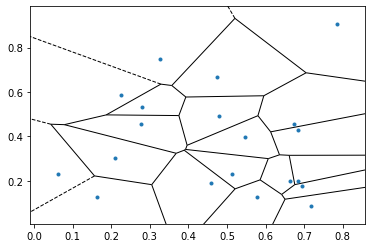

In [27]:
# EXAMPLE
# random points 
points = np.random.rand(20, 2)

# Voronoi 
thiessen = Voronoi(points)

fig, ax = plt.subplots(figsize=(6,4))
voronoi_plot_2d(thiessen, ax=ax, show_vertices=False);

In [676]:
def fireplot(df, X, Y, stations=None, site=None, color='red', sp=False):
    '''
    Function creates a plot of fires, RAWS stations, Thiessen polygons for general illustration
    df : dataframe
    Y = Latitude
    X = Longitude
    sp = False  - show_points, this is for the voronoi_plot, set to True to show
    '''
    dfc = df.copy()
    st = time.time()
    # min and max lat aand long for contiguous USA
    # Create boundary
    maxLat, minLat = 49.384358, 24.396308
    maxLong, minLong = -66.934570, -125.000000
    
    dfc[Y] = dfc[Y].apply(lambda y: None if y > maxLat or y < minLat else y)
    dfc[X]= dfc[X].apply(lambda x: None if x > maxLong or x < minLong else x)
  
    dfc.dropna(subset=[X, Y], inplace= True)
    
    # PLOT    
    fig, ax = plt.subplots(figsize=(20, 12)) 
    
    dfc.plot(x=X, y=Y, ax=ax, kind='scatter', c= 'b', label='Fires');
    
    if site:  
        nid = stations[stations['NESSID'].isin(list(df['site'].dropna().values))]
        nid.plot(x=X, y=Y, ax=ax, kind='scatter', c='black', label='RAWS Sites')
        ax.legend();
#         Draw lines between fire and station points  
        distances = []
        for index, row in nid.iterrows():
            nessid, x, y = row['NESSID'], row[X], row[Y]
            dfc_row = dfc[dfc['site'] == nessid]
            # Create grey and red lines
            for index, dfc_point in dfc_row.iterrows():
                distance = np.sqrt((x - dfc_point[X]) ** 2 + (y - dfc_point[Y]) ** 2)
                distances.append(distance)
                percentile = np.percentile(distances, 99)
                line_color = color if distance > percentile else 'grey'
                ax.plot([x, dfc_point[X]], [y, dfc_point[Y]], c=line_color);

        # attempt to run in parallel
#         def distance_check(row, nid):
#             X = row['X']
#             Y = row['Y']
#             # pull raw row
#             raw_site  = nid[nid['NESSID']==row['site']]
        
#             # fire
#             point = np.array([X, Y])
#             site_points = np.array(raw_site[['X', 'Y']])

#             # Elucidian Distance
#             distances = np.linalg.norm(site_points - point, axis=1)
# #             nearest_index = np.argmin(distances)
#             return {row['OBJECTID'] : {'distance':distances[0], 'X1':raw_site['X'].item(), 'Y1':raw_site['Y'].item()}}
            
#         from joblib import Parallel, delayed
#         presult = Parallel(n_jobs=-1, verbose=1)(
#             delayed(distance_check)(row, nid) for index, row in dfc.iterrows())
    
#         result_dict = {key: value for r in presult for key, value in r.items()}

#         for key, values in result_dict.items():
#             # Find the row index with matching 'OBJECTIID' value
#             index = dfc[dfc['OBJECTID'] == key].index

#             # Check if a matching row was found
#             if not index.empty:
#                 # Update the row with new column values
#                 dfc.loc[index, 'distance'] = values['distance']
#                 dfc.loc[index, 'X1'] = values['X1']
#                 dfc.loc[index, 'Y1'] = values['Y1']

#         def line(row):    

#             # Determine the line color based on the distance value
#             line_color = 'red' if row['distance'] >0 else 'grey'

#             # Draw a line between the points (X, Y) and (X1, Y1)
#             return [[row['X'], row['X1']], [row['Y'], row['Y1']], line_color]

#         presult2 = Parallel(n_jobs=-1, verbose=1)(
#             delayed(line)(row) for index, row in dfc.iterrows())
# #         return presult2
#         for pr in presult2:
#             ax.plot(pr[0], pr[1], c=pr[2])

    elif isinstance(stations, pd.DataFrame):
        vor = thiessen(stations, 'X', 'Y', plot=None)        
        voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=sp);
    print(time.time() - st)
#     plt.savefig('fire_site_map.png', dpi=100, bbox_inches='tight')    


In [30]:
def thiessen(df, X, Y, plot=True):
    '''
    df : Dataframe
    Y = Latitude
    X = Longitude
    plot : True, set to False to remove plot
    '''
    dfc = df.copy()
    
    maxLat, minLat = 49.384358, 24.396308
    maxLong, minLong = -66.934570, -125.000000
    
    dfc[Y] = dfc[Y].apply(lambda y: pd.NA if y > maxLat or y < minLat else y)
    dfc[X]= dfc[X].apply(lambda x: pd.NA if x > maxLong or x < minLong else x)
  
    dfc.dropna(subset=[X, Y], inplace =True)
    
    # Pull list of points
    points = list(zip(dfc[X], dfc[Y]))

    # Voronoi
    thiessen = Voronoi(points)
    
    if plot:
        fig, ax = plt.subplots(figsize=(20, 12))
        voronoi_plot_2d(thiessen, ax=ax, point_size=8, show_vertices=False)
    else:
        return thiessen

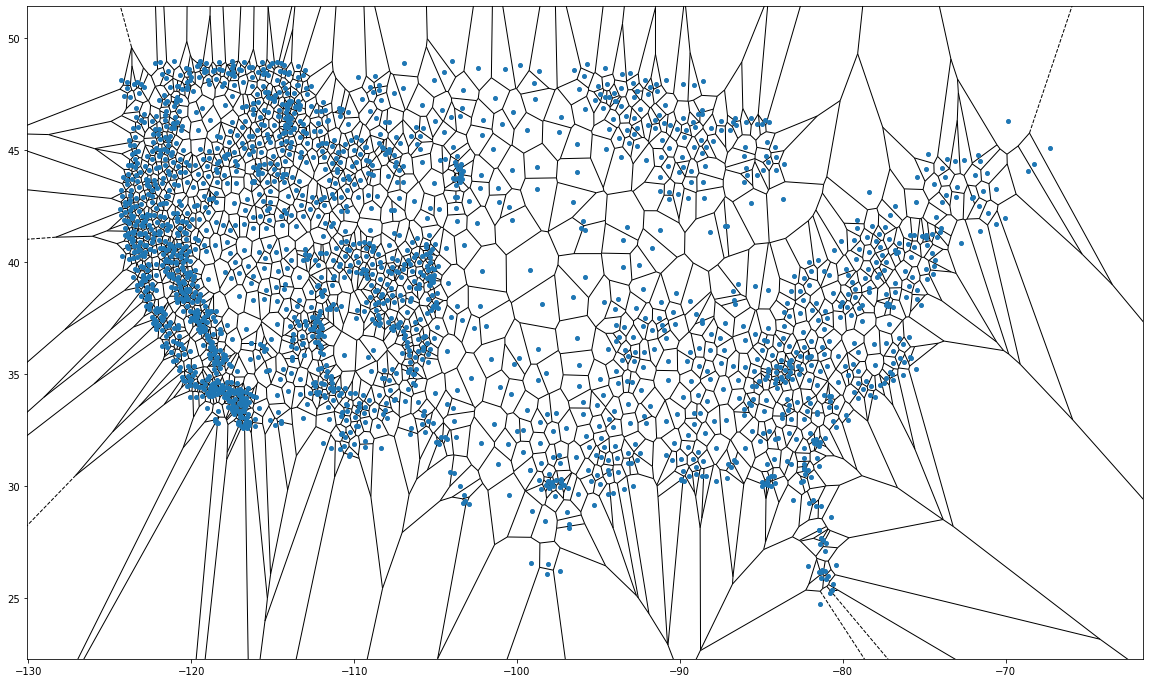

In [31]:
thiessen(df_set, 'X', 'Y')

In [689]:
# Loading in Fire locations dataset
fire_sites = pd.read_csv('Data/Wildland_Fire_Incident_Locations.csv.zip')#, low_memory=False)

In [ ]:
fire_sites.info()

In [ ]:
# Finding Wild Fire in Boulder, 2021
# US-CO
contains(fire_sites[fire_sites['POOState']== 'US-CO'], 'IncidentName', 'marshall')

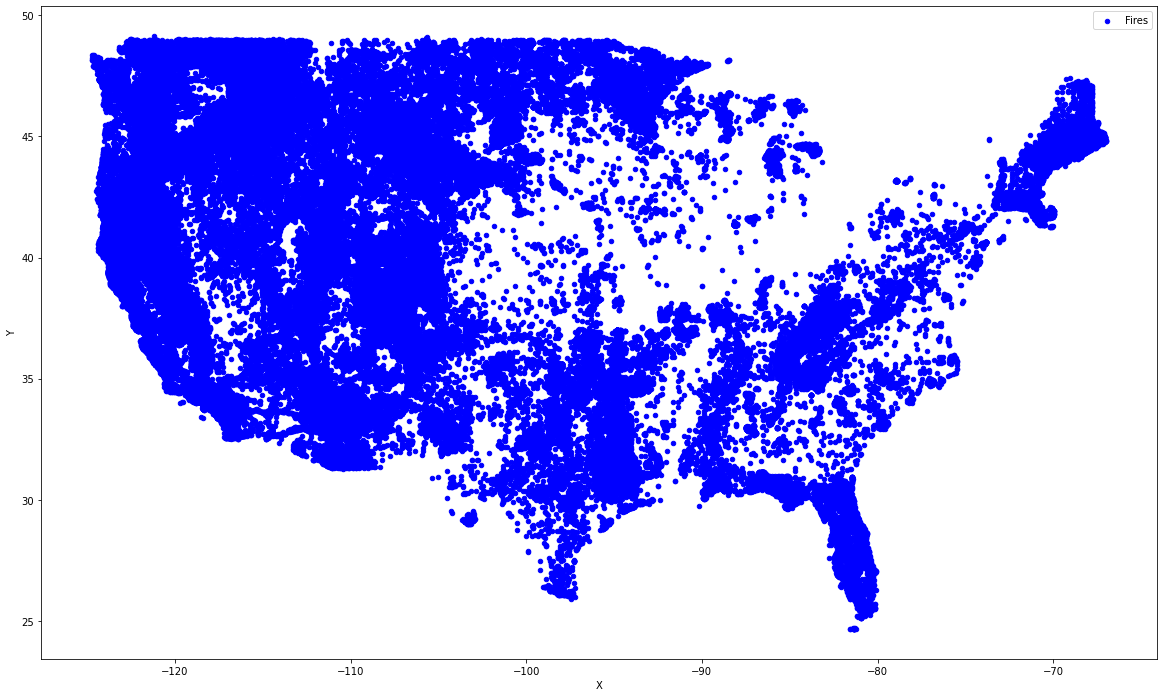

In [33]:
fireplot(fire_sites, 'X', 'Y')

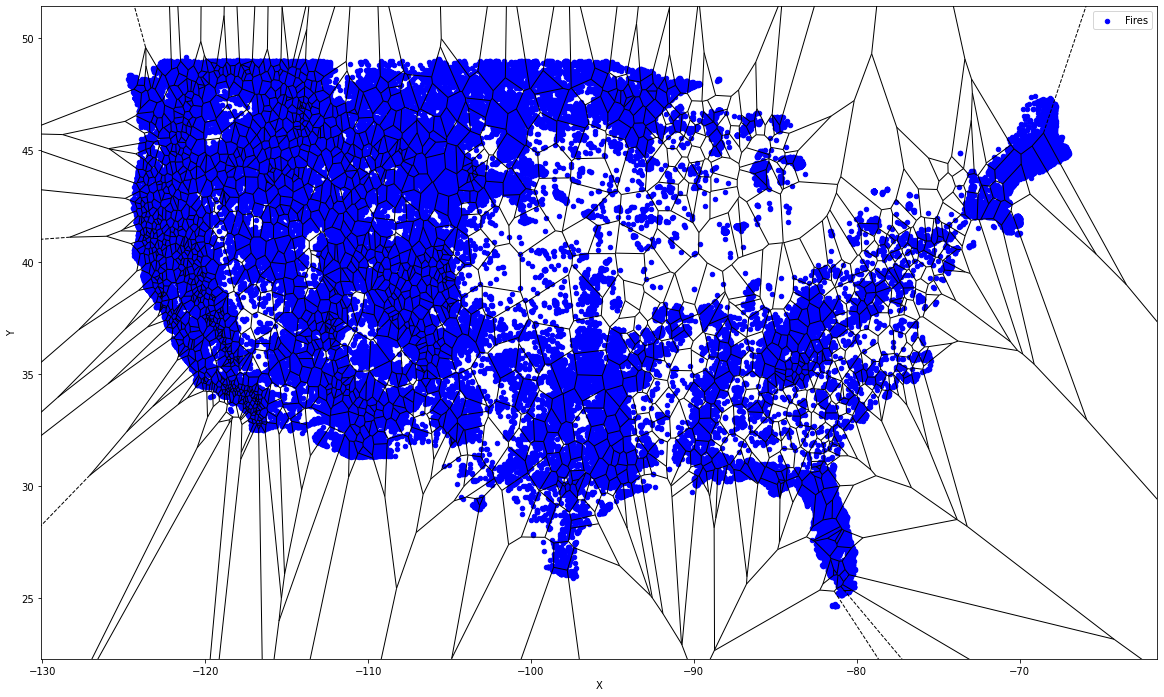

In [34]:
fireplot(fire_sites, 'X', 'Y', df_set)

<a id='Loading-in-RAWS-Stations'></a>
# Loading in RAWS Stations

    - stations_df is the IRAWS with metric data
    - stations_dates is the IRAWS but just the dates

In [38]:
stations_df = pd.read_csv('RAWS_stations.csv', header = [0,1], low_memory=False)

In [39]:
stations_df['32574066'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3393 entries, 0 to 3392
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   date                               3313 non-null   object 
 1   year                               3393 non-null   int64  
 2   day_of_year                        3393 non-null   int64  
 3   day_of_run                         3393 non-null   int64  
 4   total_solar_radiation_ly           3313 non-null   float64
 5   ave_mean_wind_speed_mph            3313 non-null   float64
 6   ave_mean_wind_direction_deg        3313 non-null   float64
 7   max_maximum_wind_gust_mph          3313 non-null   float64
 8   ave_average_air_temperature_deg_f  3313 non-null   float64
 9   max_average_air_temperature_deg_f  3313 non-null   float64
 10  min_average_air_temperature_deg_f  3313 non-null   float64
 11  ave_average_relative_humidity      3313 non-null   float

In [40]:
stations_dates = pd.read_csv('stations_dates.csv', low_memory=False)

In [41]:
stations_dates.head()

,3234455A,4870D3B2,324AD1FC,323FA500,CA41F5F8,327BC600,02609414,32336182,91C0165C,325D842A,3264B19C,326297BE,32401B62,33346214,CA21922C,6140358A,837197BA,...,324A7104,328C5342,32630026,3960060C,3390C180,CA40B408,39616110,CA2311CC,323582BE,327E82CA,324AA76C,325363B0,324BD306,39605670,3000D036,DF10101C,88400776
0,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,...,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014,02/01/2014
1,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,...,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014,02/02/2014
2,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,...,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014,02/03/2014
3,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,...,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014,02/04/2014
4,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,...,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014,02/05/2014


In [42]:
stations_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3393 entries, 0 to 3392
Columns: 1939 entries, 3234455A to 88400776
dtypes: object(1939)
memory usage: 50.2+ MB


<a id='Cleaning-RAWS-data'></a>
## Cleaning RAWS data

In [43]:
# Number of stations
def number_of_stations(df, Return=True):
    '''
    Returns the number of columns in a multilevel index, at level 0, 
    also returns a list of the columns
    '''
    col = df.columns.get_level_values(0).unique().tolist()
    print(f'Number of Stations: {len(col)}')
    if Return:
        return col

In [44]:
# should be 1939, missing 4 stations
raw_stations_list = number_of_stations(stations_df)

Number of Stations: 1935


In [45]:
def columCheck(df, inputs=False, Return=False):
    '''
    Returns the number of columns in a multilevel index at level 1, 
    also returns a list of the columns
    '''
    # list of every column at level1
    col = df.columns.get_level_values(1).unique().tolist()
    print(f'Number of Stations: {len(col)}')
    display(col)
    # list of columns that contain the input
    if inputs:
        i = inputs
    else: 
        i = input('Select name from list: ')
    if i:
        val = [l for l in df.columns if i in l[1]]
        print(f'Stations with {i}\n {val}')

    print('\nFull list\n')
    total_val = set()
    for c in col[15:]:
        val = [l[0] for l in df.columns if c in l[1]]
        total_val.update(val)    
    print(f'Stations with incorrect columns:\n {total_val}')
        

    if Return:
        return col, list(total_val)

In [46]:
ccc, bad_columns= columCheck(stations_df, Return=True)

Number of Stations: 60


['date',
 'year',
 'day_of_year',
 'day_of_run',
 'total_solar_radiation_ly',
 'ave_mean_wind_speed_mph',
 'ave_mean_wind_direction_deg',
 'max_maximum_wind_gust_mph',
 'ave_average_air_temperature_deg_f',
 'max_average_air_temperature_deg_f',
 'min_average_air_temperature_deg_f',
 'ave_average_relative_humidity',
 'max_average_relative_humidity',
 'min_average_relative_humidity',
 'total_precipitation_in',
 'date.1',
 'year.1',
 'day_of_year.1',
 'day_of_run.1',
 'total_solar_radiation_ly.1',
 'ave_mean_wind_speed_mph.1',
 'ave_mean_wind_direction_deg.1',
 'max_maximum_wind_gust_mph.1',
 'ave_average_air_temperature_deg_f.1',
 'max_average_air_temperature_deg_f.1',
 'min_average_air_temperature_deg_f.1',
 'ave_average_relative_humidity.1',
 'max_average_relative_humidity.1',
 'min_average_relative_humidity.1',
 'total_precipitation_in.1',
 'date.2',
 'year.2',
 'day_of_year.2',
 'day_of_run.2',
 'total_solar_radiation_ly.2',
 'ave_mean_wind_speed_mph.2',
 'ave_mean_wind_direction_deg.

Select name from list: 

Full list

Stations with incorrect columns:
 {'08007552', 'nan'}


In [47]:
stations_df['08007552'].head()

,date,year,day_of_year,day_of_run,total_solar_radiation_ly,ave_mean_wind_speed_mph,ave_mean_wind_direction_deg,max_maximum_wind_gust_mph,ave_average_air_temperature_deg_f,max_average_air_temperature_deg_f,min_average_air_temperature_deg_f,ave_average_relative_humidity,max_average_relative_humidity,min_average_relative_humidity,total_precipitation_in,date.1,year.1,day_of_year.1,day_of_run.1,total_solar_radiation_ly.1,ave_mean_wind_speed_mph.1,ave_mean_wind_direction_deg.1,max_maximum_wind_gust_mph.1,ave_average_air_temperature_deg_f.1,max_average_air_temperature_deg_f.1,min_average_air_temperature_deg_f.1,ave_average_relative_humidity.1,max_average_relative_humidity.1,min_average_relative_humidity.1,total_precipitation_in.1
0,02/01/2014,2014.0,32.0,1.0,34.0,1.67,113.0,7.0,14.5,26.0,2.0,84.0,90.0,73.0,0.0,02/01/2014,2014,32,1,34.0,1.66,113.0,6.5,14.5,25.5,2.3,84.0,90.0,73.0,0.0
1,02/02/2014,2014.0,33.0,2.0,44.0,2.58,319.0,13.0,14.5,23.0,4.0,77.0,89.0,56.0,0.0,02/02/2014,2014,33,2,44.0,2.57,319.0,12.8,14.5,22.6,3.8,77.0,89.0,56.0,0.0
2,02/03/2014,2014.0,34.0,3.0,70.0,2.29,173.0,12.0,10.1,21.0,2.0,74.0,85.0,51.0,0.0,02/03/2014,2014,34,3,70.0,2.40,173.0,12.1,10.1,21.0,1.6,74.0,85.0,51.0,0.0
3,02/04/2014,2014.0,35.0,4.0,44.0,1.75,74.0,9.0,16.7,26.0,9.0,75.0,86.0,57.0,0.0,02/04/2014,2014,35,4,44.0,1.77,74.0,9.3,16.8,25.7,9.3,75.0,86.0,57.0,0.0
4,02/05/2014,2014.0,36.0,5.0,69.0,3.71,342.0,15.0,12.6,20.0,8.0,67.0,77.0,45.0,0.0,02/05/2014,2014,36,5,69.0,3.77,342.0,15.2,12.6,19.6,8.2,67.0,77.0,45.0,0.0


In [48]:
stations_df['nan'].head()

,date,year,day_of_year,day_of_run,total_solar_radiation_ly,ave_mean_wind_speed_mph,ave_mean_wind_direction_deg,max_maximum_wind_gust_mph,ave_average_air_temperature_deg_f,max_average_air_temperature_deg_f,min_average_air_temperature_deg_f,ave_average_relative_humidity,max_average_relative_humidity,min_average_relative_humidity,total_precipitation_in,date.1,year.1,...,min_average_relative_humidity.2,total_precipitation_in.2,date.3,year.3,day_of_year.3,day_of_run.3,total_solar_radiation_ly.3,ave_mean_wind_speed_mph.3,ave_mean_wind_direction_deg.3,max_maximum_wind_gust_mph.3,ave_average_air_temperature_deg_f.3,max_average_air_temperature_deg_f.3,min_average_air_temperature_deg_f.3,ave_average_relative_humidity.3,max_average_relative_humidity.3,min_average_relative_humidity.3,total_precipitation_in.3
0,02/01/2014,2014.0,32.0,1.0,NaN,19.65,280.0,38.3,1.5,6.6,-2.7,75.0,78.0,72.0,0.0,02/01/2014,2014.0,...,22.0,0.00,02/01/2014,2014.0,32.0,1.0,NaN,3.30,278.0,11.1,6.5,18.8,-9.4,74.0,89.0,44.0,0.03
1,02/02/2014,2014.0,33.0,2.0,NaN,25.00,265.0,50.4,3.6,8.7,1.1,77.0,82.0,75.0,0.0,02/02/2014,2014.0,...,58.0,0.39,02/02/2014,2014.0,33.0,2.0,NaN,1.77,310.0,16.4,8.0,25.7,-8.6,76.0,85.0,51.0,0.07
2,02/03/2014,2014.0,34.0,3.0,NaN,15.33,243.0,30.0,4.9,11.8,-0.1,78.0,84.0,73.0,0.0,02/03/2014,2014.0,...,52.0,0.01,02/03/2014,2014.0,34.0,3.0,NaN,3.55,287.0,16.0,9.4,23.3,-2.3,79.0,90.0,60.0,0.01
3,02/04/2014,2014.0,35.0,4.0,NaN,12.28,51.0,27.6,-14.3,-1.2,-19.9,67.0,72.0,65.0,0.0,02/04/2014,2014.0,...,45.0,0.00,02/04/2014,2014.0,35.0,4.0,NaN,2.02,245.0,8.9,-9.2,-1.1,-19.8,75.0,82.0,61.0,0.02
4,02/05/2014,2014.0,36.0,5.0,NaN,3.83,232.0,14.5,-8.7,8.8,-15.7,69.0,80.0,66.0,0.0,02/05/2014,2014.0,...,43.0,0.00,02/05/2014,2014.0,36.0,5.0,NaN,1.68,246.0,11.8,-18.1,-8.4,-28.1,70.0,77.0,56.0,0.00


In [49]:
stations_dates['08007552']

0       02/01/2014
1       02/02/2014
2       02/03/2014
3       02/04/2014
4       02/05/2014
           ...    
3388           NaN
3389           NaN
3390           NaN
3391           NaN
3392           NaN
Name: 08007552, Length: 3393, dtype: object

In [50]:
# Convert lists back to sets
set1 = set(raw_stations_list)
set2 = set(stations_dates.columns)

# Find the extra values
set2_extra = set2 - set1
set1_extra = set1 - set2


print(f"set2:{list(set2_extra)}\nset1:{list(set1_extra)}")

set2:['Unnamed: 1517', 'Unnamed: 103', 'Unnamed: 1330', '08007552.1', 'Unnamed: 1554']
set1:['nan']


In [56]:
# From dates_df the  08007552 need to be dropped as well as all the other
#extra staations that i dont actually have data for
# stations_dates doesn't have a nan so we can just ignore that

stations_dates.drop(columns= ['08007552.1', 'Unnamed: 1517', 'Unnamed: 1554', 
                              'Unnamed: 103', 'Unnamed: 1330', '08007552'],
                   inplace= True)

## Missing stations explained
The above 2 stations for some reason contains 6 stations total, thats the 4 missing stations
- Going to just drop all 6 stations

In [57]:
stations_df1 = stations_df.copy()

In [58]:
stations_df1['nan']

,date,year,day_of_year,day_of_run,total_solar_radiation_ly,ave_mean_wind_speed_mph,ave_mean_wind_direction_deg,max_maximum_wind_gust_mph,ave_average_air_temperature_deg_f,max_average_air_temperature_deg_f,min_average_air_temperature_deg_f,ave_average_relative_humidity,max_average_relative_humidity,min_average_relative_humidity,total_precipitation_in,date.1,year.1,...,min_average_relative_humidity.2,total_precipitation_in.2,date.3,year.3,day_of_year.3,day_of_run.3,total_solar_radiation_ly.3,ave_mean_wind_speed_mph.3,ave_mean_wind_direction_deg.3,max_maximum_wind_gust_mph.3,ave_average_air_temperature_deg_f.3,max_average_air_temperature_deg_f.3,min_average_air_temperature_deg_f.3,ave_average_relative_humidity.3,max_average_relative_humidity.3,min_average_relative_humidity.3,total_precipitation_in.3
0,02/01/2014,2014.0,32.0,1.0,NaN,19.65,280.0,38.3,1.5,6.6,-2.7,75.0,78.0,72.0,0.0,02/01/2014,2014.0,...,22.0,0.00,02/01/2014,2014.0,32.0,1.0,NaN,3.30,278.0,11.1,6.5,18.8,-9.4,74.0,89.0,44.0,0.03
1,02/02/2014,2014.0,33.0,2.0,NaN,25.00,265.0,50.4,3.6,8.7,1.1,77.0,82.0,75.0,0.0,02/02/2014,2014.0,...,58.0,0.39,02/02/2014,2014.0,33.0,2.0,NaN,1.77,310.0,16.4,8.0,25.7,-8.6,76.0,85.0,51.0,0.07
2,02/03/2014,2014.0,34.0,3.0,NaN,15.33,243.0,30.0,4.9,11.8,-0.1,78.0,84.0,73.0,0.0,02/03/2014,2014.0,...,52.0,0.01,02/03/2014,2014.0,34.0,3.0,NaN,3.55,287.0,16.0,9.4,23.3,-2.3,79.0,90.0,60.0,0.01
3,02/04/2014,2014.0,35.0,4.0,NaN,12.28,51.0,27.6,-14.3,-1.2,-19.9,67.0,72.0,65.0,0.0,02/04/2014,2014.0,...,45.0,0.00,02/04/2014,2014.0,35.0,4.0,NaN,2.02,245.0,8.9,-9.2,-1.1,-19.8,75.0,82.0,61.0,0.02
4,02/05/2014,2014.0,36.0,5.0,NaN,3.83,232.0,14.5,-8.7,8.8,-15.7,69.0,80.0,66.0,0.0,02/05/2014,2014.0,...,43.0,0.00,02/05/2014,2014.0,36.0,5.0,NaN,1.68,246.0,11.8,-18.1,-8.4,-28.1,70.0,77.0,56.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
def adjust_column_names(df):
    '''
    Modifies the DataFrame columns at level 0 of the multi-level index to the specified header list.
    '''
    header = ['date', 'year', 'day_of_year', 'day_of_run', 'total_solar_radiation_ly',
          'ave_mean_wind_speed_mph', 'ave_mean_wind_direction_deg', 'max_maximum_wind_gust_mph',
          'ave_average_air_temperature_deg_f', 'max_average_air_temperature_deg_f',
          'min_average_air_temperature_deg_f', 'ave_average_relative_humidity',
          'max_average_relative_humidity', 'min_average_relative_humidity', 'total_precipitation_in']
    
    col = df.columns.get_level_values(0).unique().tolist()
    try:
        for c in col:
            df[c].set_axis(header, axis=1, inplace=True)
        return df
    except Exception as e:
        print(e)

In [60]:
adjust_column_names(stations_df1)


Length mismatch: Expected axis has 60 elements, new values have 15 elements


### The above failed, just going to drop the stations with this issue

In [61]:
bad_columns

['08007552', 'nan']

In [62]:
stations_df1.drop(columns= bad_columns, level=0, inplace= True)

In [63]:
# Checking if dropping the bad columns worked
columCheck(stations_df1)

Number of Stations: 15


['date',
 'year',
 'day_of_year',
 'day_of_run',
 'total_solar_radiation_ly',
 'ave_mean_wind_speed_mph',
 'ave_mean_wind_direction_deg',
 'max_maximum_wind_gust_mph',
 'ave_average_air_temperature_deg_f',
 'max_average_air_temperature_deg_f',
 'min_average_air_temperature_deg_f',
 'ave_average_relative_humidity',
 'max_average_relative_humidity',
 'min_average_relative_humidity',
 'total_precipitation_in']

Select name from list: 

Full list

Stations with incorrect columns:
 set()


In [64]:
# Get the list of unique level 0 column names
col = stations_df1.columns.get_level_values(0).unique().tolist()

# Convert 'date' column to datetime
for c in col:
    stations_df1[(c, 'date')] = pd.to_datetime(stations_df1[(c, 'date')], errors='coerce')


In [65]:
# Drop specified columns
columns_to_drop = ['year', 'day_of_year', 'day_of_run', 'max_average_air_temperature_deg_f', 
                   'min_average_air_temperature_deg_f', 'max_average_relative_humidity', 
                   'min_average_relative_humidity']
stations_df1.drop(columns=columns_to_drop, level=1, inplace=True)

In [66]:
stations_df1['3234455A'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3393 entries, 0 to 3392
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   date                               3371 non-null   datetime64[ns]
 1   total_solar_radiation_ly           3371 non-null   float64       
 2   ave_mean_wind_speed_mph            3371 non-null   float64       
 3   ave_mean_wind_direction_deg        3371 non-null   float64       
 4   max_maximum_wind_gust_mph          3371 non-null   float64       
 5   ave_average_air_temperature_deg_f  3371 non-null   float64       
 6   ave_average_relative_humidity      3371 non-null   float64       
 7   total_precipitation_in             3371 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 212.2 KB


In [67]:
stations_df1.head()

3234455A                                                   \
        date total_solar_radiation_ly ave_mean_wind_speed_mph   
0 2014-02-01                    270.0                    0.42   
1 2014-02-02                    207.0                    3.50   
2 2014-02-03                    114.0                    0.96   
3 2014-02-04                    237.0                    5.71   
4 2014-02-05                    294.0                    4.92   

                                                         \
  ave_mean_wind_direction_deg max_maximum_wind_gust_mph   
0                        93.0                      12.0   
1                       146.0                      20.0   
2                       232.0                      15.0   
3                       120.0                      16.0   
4                       122.0                      17.0   

                                                                   \
  ave_average_air_temperature_deg_f ave_average_relative_humidity   
0                              26.3                          74.0   
1                              17.6                          67.0   
2                              24.8                          62.0   
3                              12.7                          44.0   
4                               6.2                          44.0   

                           4870D3B2                           \
  total_precipitation_in       date total_solar_radiation_ly   
0                   0.07 2014-02-01                    495.0   
1                   0.00 2014-02-02                    370.0   
2                   0.01 2014-02-03                    214.0   
3                   0.00 2014-02-04                    123.0   
4                   0.00 2014-02-05                    465.0   

                                                       \
  ave_mean_wind_speed_mph ave_mean_wind_direction_deg   
0                    7.83                       168.0   
1                    7.50                       173.0   
2                    4.67                       222.0   
3                    5.21                        87.0   
4                    6.08                        40.0   

                                                               \
  max_maximum_wind_gust_mph ave_average_air_temperature_deg_f   
0                      18.0                              55.4   
1                      17.0                              55.9   
2                      18.0                              54.0   
3                      17.0                              52.1   
4                      14.0                              56.9   

                                                         324AD1FC  ...  \
  ave_average_relative_humidity total_precipitation_in       date  ...   
0                          75.0                   0.00 2014-02-01  ...   
1                          82.0                   0.08 2014-02-02  ...   
2                          95.0                   0.29 2014-02-03  ...   
3                          94.0                   0.01 2014-02-04  ...   
4                          66.0                   0.00 2014-02-05  ...   

                3000D036   DF10101C                           \
  total_precipitation_in       date total_solar_radiation_ly   
0                   0.36 2014-02-01                    273.0   
1                   0.05 2014-02-02                    207.0   
2                   0.00 2014-02-03                     28.0   
3                   0.00 2014-02-04                    248.0   
4                   0.00 2014-02-05                     46.0   

                                                       \
  ave_mean_wind_speed_mph ave_mean_wind_direction_deg   
0                    2.75                       146.0   
1                    2.08                       300.0   
2                    5.42                        28.0   
3                    3.54                        42.0   
4                    7.04          

<a id='Fire-Occurrences-eda'></a>
# Fire Occurrences EDA
- Using dataFrame fire_sites

[Go to Top](#top)

In [684]:
# various columns in fire_sites, Ended up using all that is selected
keep = ['IncidentSize', 'EstimatedCostToDate', 'FinalAcres', 'FireCause', 'PrimaryFuelModel',
        'EstimatedFinalCost', 'IncidentName']

maybe = ['FireCauseGeneral', 'FireCauseSpecific', 'DiscoveryAcres', 'FireMgmtComplexity',
         'IncidentShortDescription']

keep1 = ['X','Y', 'OBJECTID','ContainmentDateTime','ControlDateTime','FireDiscoveryDateTime',
                                'FireOutDateTime']

keep3 = ['DispatchCenterID', 'ABCDMisc', 'FireCode', 'FireDepartmentID', 'GACC', 'POODispatchCenterID', 
         'POOCounty','POOFips', 'POOJurisdictionalAgency', 'POOJurisdictionalUnit', 'POOState']

fire_test = fire_sites[keep1 + maybe + keep + keep3]
fire_test.head()

NameError: name 'fire_sites' is not defined

In [69]:
fire_test.isna().sum()

X                                0
Y                                0
OBJECTID                         0
ContainmentDateTime         102796
ControlDateTime             118401
FireDiscoveryDateTime            0
FireOutDateTime             109938
FireCauseGeneral            201737
FireCauseSpecific           241832
DiscoveryAcres               65383
FireMgmtComplexity          234285
IncidentShortDescription    247801
IncidentSize                 76637
EstimatedCostToDate         242591
FinalAcres                  238393
FireCause                    31610
PrimaryFuelModel            240503
EstimatedFinalCost          255773
IncidentName                     9
DispatchCenterID             37378
ABCDMisc                    244544
FireCode                    127669
FireDepartmentID            246920
GACC                            61
POODispatchCenterID          77599
POOCounty                      161
POOFips                        168
POOJurisdictionalAgency     147810
POOJurisdictionalUni

In [70]:
print(f'Over 50% Are Nulls:\n{"-"*45}\n{fire_test.isna().sum() > (len(fire_test)/2)}')

Over 50% Are Nulls:
---------------------------------------------
X                           False
Y                           False
OBJECTID                    False
ContainmentDateTime         False
ControlDateTime             False
FireDiscoveryDateTime       False
FireOutDateTime             False
FireCauseGeneral             True
FireCauseSpecific            True
DiscoveryAcres              False
FireMgmtComplexity           True
IncidentShortDescription     True
IncidentSize                False
EstimatedCostToDate          True
FinalAcres                   True
FireCause                   False
PrimaryFuelModel             True
EstimatedFinalCost           True
IncidentName                False
DispatchCenterID            False
ABCDMisc                     True
FireCode                    False
FireDepartmentID             True
GACC                        False
POODispatchCenterID         False
POOCounty                   False
POOFips                     False
POOJurisdictiona

In [71]:
# checking length of target
len(fire_test[~fire_test['FireMgmtComplexity'].isna()])

23340

Fire Acres contains many nulls, below I evaluate the column called incidentsize to determine if it is the same units or similar to final acres

In [72]:
fire_size = fire_test[(~fire_test['FinalAcres'].isna()) & (~fire_test['IncidentSize'].isna())]
fire_size = fire_size[['FinalAcres', 'IncidentSize']]
fire_size

,FinalAcres,IncidentSize
9215,0.00,0.00
36489,0.00,0.00
70726,0.00,0.00
72652,492.30,400.10
72914,0.01,0.01
...,...,...
257568,5.00,5.00
257570,0.50,0.50
257574,1.00,1.00
257602,2.00,2.00


- many of the values are similar aand i have good reason to believe incident size is in acres,
- all values missing acres but has incidentsize will be used
<a id="similar-feature-acres"></a>

In [73]:
# replace null acres with their incident size
fire_test['FinalAcres'].fillna(fire_test['IncidentSize'], inplace=True)
fire_test.drop(columns='IncidentSize', inplace=True)

    

/Users/keanan/opt/anaconda3/envs/flatiron-env/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/keanan/opt/anaconda3/envs/flatiron-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [74]:
# Rechecking the nulls
fire_test.isna().sum()

X                                0
Y                                0
OBJECTID                         0
ContainmentDateTime         102796
ControlDateTime             118401
FireDiscoveryDateTime            0
FireOutDateTime             109938
FireCauseGeneral            201737
FireCauseSpecific           241832
DiscoveryAcres               65383
FireMgmtComplexity          234285
IncidentShortDescription    247801
EstimatedCostToDate         242591
FinalAcres                   70980
FireCause                    31610
PrimaryFuelModel            240503
EstimatedFinalCost          255773
IncidentName                     9
DispatchCenterID             37378
ABCDMisc                    244544
FireCode                    127669
FireDepartmentID            246920
GACC                            61
POODispatchCenterID          77599
POOCounty                      161
POOFips                        168
POOJurisdictionalAgency     147810
POOJurisdictionalUnit        92977
POOState            

In [75]:
# Renaming all columns with date that shouldn't be datetime
fire_test.rename(columns={'EstimatedCostToDate': 'EstimatedCostTodate'}, inplace=True)


/Users/keanan/opt/anaconda3/envs/flatiron-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [76]:
# Setting datetime
def datetimes(df, dates=None, normal=True):
    '''
    df : dataframe
    dates : list of columns to perform datetime on, if none only columns with Date in name is used
    normal : True, False will not use format='%Y-%m-%d'
    '''
    if not dates:
        dates = list(df.columns[df.columns.str.contains('Date')])
    if normal:
        for t in dates:
            df[t] = pd.to_datetime(df[t], errors='coerce', format='%Y-%m-%d')
            df[t] = df[t].dt.tz_localize(None)
            print('Used Format Y-m-d')
    else:
        for t in dates:
            df[t] = pd.to_datetime(df[t], errors='coerce')
            
datetimes(fire_test)

<ipython-input-76-c499f70d71c7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[t] = pd.to_datetime(df[t], errors='coerce', format='%Y-%m-%d')#.dt.normalize()
<ipython-input-76-c499f70d71c7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[t] = df[t].dt.tz_localize(None)


Used Format Y-m-d
Used Format Y-m-d
Used Format Y-m-d
Used Format Y-m-d


In [77]:
# Setting all columns as date time
datetimes(stations_dates, list(stations_dates.columns), normal=False)

<a id="similar-feature-fireout-time"></a>

In [78]:
def fixer(df):
    '''
    Function to further clean fire occurences dataset
    '''
    # remove any year thats older then 2014 (dataset is only supposed to go back to 2014)
    datetime_columns = list(df.select_dtypes(['datetime64[ns, UTC]', 'datetime64[ns]']).columns)
    
    # Replace missing FireOutDateTime values with ContainmentDateTime values
    dropped = []
    for dc in datetime_columns:
        df['year'] = df[dc].dt.year
        dropped.extend(df[df['year'] < 2014].values)
        df = df[df['year'] >= 2014]
#         dropped.extend(df[df['year'] < 2014].index)
    df.drop(columns='year', inplace=True)
      
        
    # Replacing null fireoutdatetime with containment datetime
    df['FireOutDateTime'].fillna(df['ContainmentDateTime'], inplace=True)
    
    # Drop any fire out day that is after the current date, as thats impossible 
    from datetime import datetime
    # Todays date
    today = datetime.now().date()

    # Drop rows where FireOutDateTime is greater then today
    dropped.extend(df[df['FireOutDateTime'].dt.date > today].values)
    df = df[df['FireOutDateTime'].dt.date <= today]
    
    # Drop rows where FireOutDateTime is greater then FireDiscoveryDateTime
    dropped.extend(df[df['FireOutDateTime'].dt.date >= df['FireDiscoveryDateTime'].dt.date].values)
    df = df[df['FireOutDateTime'].dt.date >= df['FireDiscoveryDateTime'].dt.date]


    # Final drop
    df.drop(columns=['ContainmentDateTime','ControlDateTime'], inplace=True)
    
    return df, dropped

fire_test, dropped_rows = fixer(fire_test)
fire_test.head()

<ipython-input-78-e1039468ab7e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df[dc].dt.year
<ipython-input-78-e1039468ab7e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df[dc].dt.year


,X,Y,OBJECTID,FireDiscoveryDateTime,FireOutDateTime,FireCauseGeneral,FireCauseSpecific,DiscoveryAcres,FireMgmtComplexity,IncidentShortDescription,EstimatedCostTodate,FinalAcres,FireCause,PrimaryFuelModel,EstimatedFinalCost,IncidentName,DispatchCenterID,ABCDMisc,FireCode,FireDepartmentID,GACC,POODispatchCenterID,POOCounty,POOFips,POOJurisdictionalAgency,POOJurisdictionalUnit,POOState
371,-107.464712,45.622997,372,2022-09-19 06:08:00,2022-11-07 18:04:59,NaN,NaN,1.0,NaN,NaN,NaN,0.1,Undetermined,NaN,NaN,River Road D 2,MTBDC,NaN,P2HV,NaN,NRCC,MTBDC,Big Horn,30003,NaN,NaN,US-MT
670,-108.840411,37.245426,671,2022-08-09 21:32:00,2022-08-15 20:39:00,NaN,NaN,0.1,NaN,NaN,NaN,0.1,Natural,NaN,NaN,Black Mountain,CODRC,NaN,PZL4,NaN,RMCC,CODRC,Montezuma,08083,BIA,COUMA,US-CO
1817,-121.604615,47.638906,1818,2022-09-02 20:08:00,2022-12-16 21:13:00,NaN,NaN,0.1,Type 4 Incident,Lock Katrine in Alpine Lakes Wilderness. Priva...,2000000.0,1225.0,Undetermined,Closed Timber Litter,3100000.0,Loch Katrine,WAPSC,NaN,P1LW,NaN,NWCC,WAPSC,King,53033,USFS,WAMSF,US-WA
5842,-110.770411,33.117105,5843,2022-03-14 20:25:00,2022-03-15 02:00:00,NaN,NaN,0.1,NaN,NaN,NaN,0.1,Human,NaN,NaN,ND 143,AZTDC,NaN,P4WF,NaN,SWCC,AZTDC,Gila,04007,BLM,AZGID,US-AZ
12572,-108.972811,38.758058,12575,2022-07-17 23:48:59,2022-12-20 17:19:59,NaN,NaN,0.1,NaN,NaN,NaN,0.1,Natural,NaN,NaN,Palisades,COGJC,NaN,PV54,NaN,RMCC,COGJC,Mesa,08077,BLM,COGRD,US-CO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257521,-116.656414,47.613426,307102,2023-05-04 18:32:00,2023-05-04 19:55:00,NaN,NaN,0.1,NaN,NaN,NaN,0.1,Human,NaN,NaN,Mineral,IDCDC,NaN,P7SE,NaN,NRCC,IDCDC,Kootenai,16055,USFS,IDIPF,US-ID
257539,-111.490511,32.712385,307122,2023-05-04 19:50:59,2023-05-05 14:35:00,NaN,NaN,1.0,NaN,NaN,NaN,26.7,Human,NaN,NaN,Pine,AZADC,NaN,P7SJ,NaN,SWCC,AZTDC,Pinal,04021,NaN,NaN,US-AZ
257557,-95.855345,47.085820,307143,2023-05-04 22:05:00,2023-05-05 23:48:59,Arson,Hot set,NaN,NaN,NaN,NaN,72.0,Human,NaN,NaN,South project,MNMNCC,NaN,P7SR,NaN,EACC,MNMNCC,Becker,27005,BIA,MNMNA,US-MN
257590,-114.248212,35.382985,307191,2023-05-05 03:45:43,2023-05-05 04:40:00,NaN,NaN,0.1,NaN,NaN,NaN,0.1,Human,NaN,NaN,Chloride,AZADC,NaN,NaN,NaN,SWCC,AZPDC,Mohave,04015,DFFM,AZA5S,US-AZ


<a id='duration'></a>
# Duration
Calculating duration to for RAWS site pulling, this is used to check if a RAWS has data for atleast 50% of the duration a fire occurs 

In [79]:
# duration of each fire 
fire_test['duration'] = fire_test['FireOutDateTime'] - fire_test['FireDiscoveryDateTime']
fire_test['duration'] = fire_test['duration'].dt.days

In [80]:
def findfire(day):
    '''
    Function: Locates fires occurences based on input year
    '''
    fire_test1 = fire_test.copy()
    fire_test1.reset_index(inplace=True)

    return fire_test1[fire_test1['FireOutDateTime'].dt.date == pd.to_datetime(day).date()]

In [81]:
findfire('2023')

,index,X,Y,OBJECTID,FireDiscoveryDateTime,FireOutDateTime,FireCauseGeneral,FireCauseSpecific,DiscoveryAcres,FireMgmtComplexity,IncidentShortDescription,EstimatedCostTodate,FinalAcres,FireCause,PrimaryFuelModel,EstimatedFinalCost,IncidentName,DispatchCenterID,ABCDMisc,FireCode,FireDepartmentID,GACC,POODispatchCenterID,POOCounty,POOFips,POOJurisdictionalAgency,POOJurisdictionalUnit,POOState,duration
11963,97892,-119.065715,48.766786,102122,2022-08-01 04:24:09,2023-01-01 07:59:00,NaN,NaN,0.1,NaN,NaN,NaN,0.1,Natural,NaN,NaN,BONAPARTE BOG,WANEC,NaN,NaN,NaN,NWCC,WANEC,Okanogan,53047,NaN,NaN,US-WA,153
103506,217152,-122.012615,46.461046,253772,2022-11-17 21:11:43,2023-01-01 00:00:00,NaN,NaN,0.1,NaN,NaN,NaN,86.9,Human,NaN,NaN,FOOT ROT,WAPCC,NaN,NaN,NaN,NWCC,WACCC,Lewis,53041,NaN,NaN,US-WA,44
126462,247648,-94.566597,35.720216,292902,2023-01-01 00:30:00,2023-01-01 02:00:00,NaN,NaN,1.1,NaN,NaN,NaN,1.1,Human,NaN,NaN,SYCAMORE,ARAOC,NaN,P42E,NaN,SACC,ARAOC,Adair,40001,Tribal,OKCNA,US-OK,0


<a id='Dropping all points outside of the contiguous USA'></a>
# Dropping all points outside of the contiguous USA

This is done to reduce size and risk of irregularities along islands and other points that appear to be in the oceaan

In [669]:
# Pulling nessid for each site,
nessid_df = df_set[['NESSID', 'X', 'Y']]#.set_index('NESSID')

In [83]:
def conti(site):   
    '''
    This function assumes lat and long are X and Y
    limits dataset to only contiguous USA
    '''
    max_lat, min_lat = 49.384358, 24.396308
    max_long, min_long = -66.934570, -125.000000

    site['Y'] = site['Y'].apply(lambda y: np.nan if y > max_lat or y < min_lat else y)
    site['X'] = site['X'].apply(lambda x: np.nan if x > max_long or x < min_long else x)
    site.dropna(subset=['X', 'Y'], inplace =True)
    return site
fire_test = conti(fire_test)

In [84]:
fire_test1 = fire_test.copy()

In [86]:
def set_index(dfs):
    '''
    Set index to be a list of dates
    dfs : dataframe
    
    Input should be a dataframe with all values as dates, assumes each row is a unique date or a null
    Redundency statement checks for this. 
    '''
    df = dfs.copy()
    dates = []

    # Iterate over each row in DataFrame
    for index, row in df.iterrows():
        # Find the date value in the row
        date_value = pd.to_datetime(row.values, errors='coerce')

        # Check if the date value is unique in the row, Redundancy check
        if date_value.nunique() != 1:
            print(f"Non-unique date value found in row {index}")

        # Add date value to the list
        dates.append(date_value[0])

    # set index to be list of days in DataFrame
    df.index = dates
    return df
stations_dates5 = set_index(stations_dates)

In [87]:
# setting dates to dt.date for fire dataset
fire_test1['FireDiscoveryDateTime'] = fire_test1['FireDiscoveryDateTime'].dt.date
fire_test1['FireOutDateTime'] = fire_test1['FireOutDateTime'].dt.date

<a id='Fire Incidents RAWS'></a>
# Fire Incidents RAWS

For each fire duration, data from remote access weather stations that provided data for 50% or more of the duration were collected. The closest weather station was then assigned to the fire incident. The assigned weather station's average values for each parameter were used to represent the meteorological characteristics over the entire duration.

In [88]:
def poly_site(row ,site, nessid):
    '''
    x : X coordinate (longitude)
    y : Y coordinate (latitude)
    row : dataframe row as a series
    site : RAWS dates dataframe, all values should be dates, index also dates
    nessid : RAWS with nessid, X and Y
    
    Function:
    Find RAWS closest to Fire incident that has data for atleast 50% of the fires duration
    
    1. Pulls all RAWS between fire start and end date, if more then half the days are null then drop RAWS
    2. If start or end date doesn't exsit in site data, then reduce duration by one day, removing missing day
    3. pull all rows in nessid that are in filtered site, columns in site are NEESSID values,
    4. pull all X and Y for filtered nessid, find site closest to fire incident
    5. return fire objectid and site nessid 
    '''
    X = row['X']
    Y = row['Y']
    obid = row['OBJECTID']
    start, end = row['FireDiscoveryDateTime'], row['FireOutDateTime']
    duration = row['duration'] 
 
    # pulling all sites between start and end dates
    # Recursive function will adjust start and end date if current date doesn't exist
    def recursive_time(site, start, end, duration):
        try:
            filtered_data = site.loc[start:end].dropna(axis=1, thresh=duration / 2)
            return filtered_data
        except Exception as e:
            if e.args[0].date() == end:        
                end = end - timedelta(days=1)    
            elif e.args[0].date() == start:
                start = start + timedelta(days=1)  
        
            return recursive_time(site, start, end, duration)
    # if duration <= 1 day , then drop RAWS if null       
    if duration <= 1:
        try:
            filtered_data = site.loc[start:end].dropna(axis=1)
        except:
            # if it fails then there is no site with data for this day
            return {obid : np.nan}
    else:
        filtered_data = recursive_time(site, start, end, duration) 
        
    nid = nessid[nessid['NESSID'].isin(filtered_data.columns)].reset_index(drop=True)
#     return nid
    # Create arrays for elucidian calculation
    point = np.array([X, Y])
    site_points = np.array(nid[['X', 'Y']])
    
    # Elucidian Distance
    distances = np.linalg.norm(site_points - point, axis=1)
    nearest_index = np.argmin(distances)

    return {obid : nid.iloc[nearest_index]['NESSID']}


In [89]:
# Running poly_site function with parallel processing

# Use Parallel
results = Parallel(n_jobs=-1, verbose=1)(
    delayed(poly_site)(row, stations_dates5, nessid_df) for index, row in fire_test1.iterrows()
)

# create one dict, from the nest
result_dict = {key: value for r in results for key, value in r.items()}
# Add sites to new column
fire_test1['site'] = fire_test1['OBJECTID'].map(result_dict)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2976 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 5776 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 9376 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 13776 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 18976 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 24976 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 31776 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 39376 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 47776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 56976 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 66976 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 77776 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 89376 t

In [90]:
# number of missing sites
fire_test1['site'].isna().sum()

18

13.713191986083984

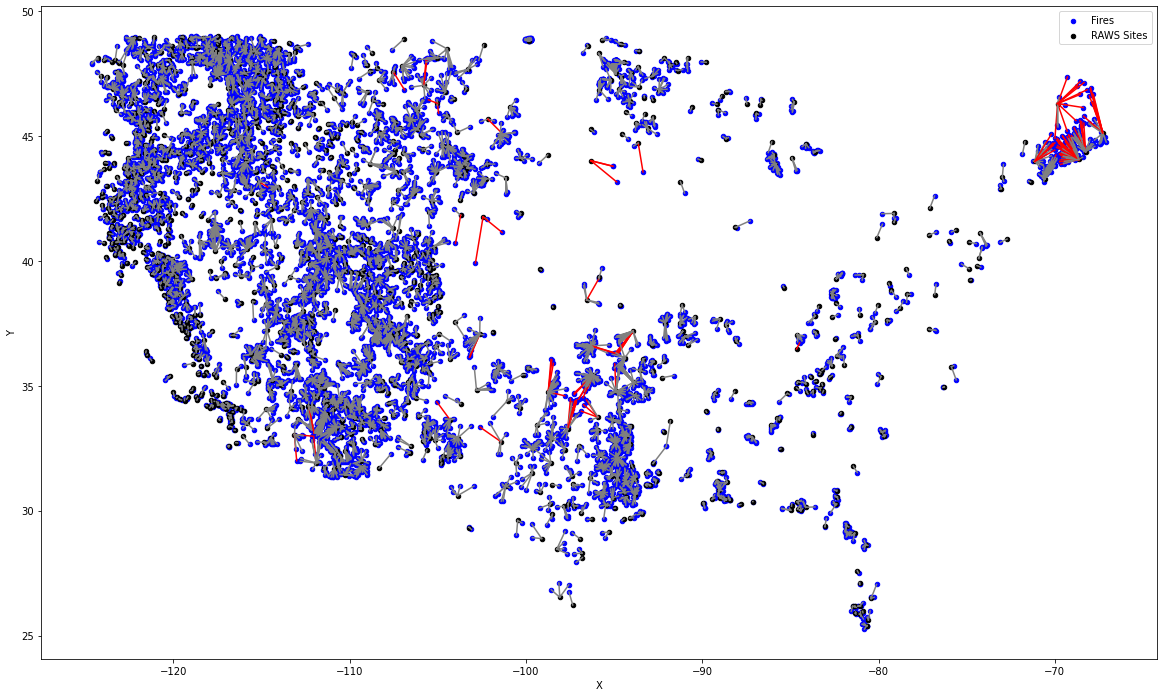

In [91]:
# Plot showing fire incidents and the closest usable RAW
# Red line indicates farther then 99% of the other pairs
st = time.time()
fireplot(fire_test1[:10000], 'X', 'Y', nessid_df, True)
time.time() - st

<a id='Pulling the mean values for each fire'></a>
# Pulling the mean values for each fire                                                        
[Go to Top](#top)


In [92]:
# drop all nulls in subset site
fire_test1.dropna(subset=['site'], inplace=True)

In [93]:
# check for nulls
fire_test1['site'].isna().sum()

0

In [94]:
# create df for all used RAWS stations
final_raws = stations_df1[set(r for r in list(fire_test1['site']) if r is not np.nan)]
number_of_stations(final_raws, Return=False)

Number of Stations: 1512


In [95]:
final_raws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3393 entries, 0 to 3392
Columns: 12096 entries, ('327307B8', 'date') to ('3287439C', 'total_precipitation_in')
dtypes: datetime64[ns](1512), float64(9937), int64(647)
memory usage: 313.1 MB


In [96]:
def final_eda(row, site):
    '''
    row : fire incident dataframe rows
    site : RAWS stations full dataframe, multilevel index
    For each fire incident, locate RAWS (nessid) and calculate the mean for data over its duration. 
    returns dictionary with objectid and dataframe with the mean values 
    '''
    start, end = row['FireDiscoveryDateTime'], row['FireOutDateTime']
    
    # pull the site dataframe
    picked_site = site[row['site']]
    # pull all rows between start and end date
    picked_site = picked_site[(picked_site['date'].dt.date >= start) & (picked_site['date'].dt.date <= end)]

    return {row['OBJECTID'] : picked_site.mean(numeric_only=True)} #numeric_only=True

In [99]:
fire_final = fire_test1.copy()

In [103]:
# Using parallel processing to run final_eda
results_eda = Parallel(n_jobs=-1, verbose=1)(
    delayed(final_eda)(row, final_raws) for index, row in fire_final.iterrows()
)

st = time.time()
# create one dict, from the nest
result_dict = {key: value for r in results_eda for key, value in r.items()}
print(f"Total Run Time: {time.time()- st}")

# take output dict and add to dataframe
st = time.time()
for key, value in result_dict.items():
    fire_final.loc[fire_final['OBJECTID'] == key, value.index] = value.values
print(f"Total Run Time: {time.time()- st}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5800 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 11400 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 18600 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 27400 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 37800 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 49800 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 63400 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 78600 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 95400 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 113800 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 124369 out of 124369 | elapsed:  3.1min finished


Total Run Time: 0.30333423614501953
Total Run Time: 445.47034335136414


<a id='Final dataset EDA'></a>
# Final dataset EDA

In [106]:
# Checking for nulls in meteorological 
fire_final.isna().sum()

X                                         0
Y                                         0
OBJECTID                                  0
FireDiscoveryDateTime                     0
FireOutDateTime                           0
FireCauseGeneral                      91013
FireCauseSpecific                    113574
DiscoveryAcres                        15656
FireMgmtComplexity                   112376
IncidentShortDescription             119780
EstimatedCostTodate                  117767
FinalAcres                             6247
FireCause                              1855
PrimaryFuelModel                     116933
EstimatedFinalCost                   122988
IncidentName                              0
DispatchCenterID                      11755
ABCDMisc                             112721
FireCode                              44952
FireDepartmentID                     122006
GACC                                     29
POODispatchCenterID                   43910
POOCounty                       

In [108]:
fire_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124369 entries, 371 to 257593
Data columns (total 36 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   X                                  124369 non-null  float64
 1   Y                                  124369 non-null  float64
 2   OBJECTID                           124369 non-null  int64  
 3   FireDiscoveryDateTime              124369 non-null  object 
 4   FireOutDateTime                    124369 non-null  object 
 5   FireCauseGeneral                   33356 non-null   object 
 6   FireCauseSpecific                  10795 non-null   object 
 7   DiscoveryAcres                     108713 non-null  float64
 8   FireMgmtComplexity                 11993 non-null   object 
 9   IncidentShortDescription           4589 non-null    object 
 10  EstimatedCostTodate                6602 non-null    float64
 11  FinalAcres                         11

In [110]:
# dropping rows that have null weather values
fire_final.dropna(subset=['total_solar_radiation_ly', 'ave_mean_wind_speed_mph', 'ave_mean_wind_direction_deg',
'max_maximum_wind_gust_mph', 'ave_average_air_temperature_deg_f', 'ave_average_relative_humidity',
'total_precipitation_in'], inplace=True)

<a id='Data Checkpoint'></a>
# Data Checkpoint
- [Go to Data Checkpoint 2](#Data-Checkpoint-2)

In [42]:
# Saving fire to a final dataset
# fire_final.to_csv('clean_fire_data.csv', index=False)
fire_final = pd.read_csv('Data/clean_fire_data.csv.zip', low_memory=False)

In [536]:
fire_final

,X,Y,OBJECTID,FireDiscoveryDateTime,FireOutDateTime,FireCauseGeneral,FireCauseSpecific,DiscoveryAcres,FireMgmtComplexity,IncidentShortDescription,EstimatedCostTodate,FinalAcres,FireCause,PrimaryFuelModel,EstimatedFinalCost,IncidentName,DispatchCenterID,...,FireDepartmentID,GACC,POODispatchCenterID,POOCounty,POOFips,POOJurisdictionalAgency,POOJurisdictionalUnit,POOState,duration,site,total_solar_radiation_ly,ave_mean_wind_speed_mph,ave_mean_wind_direction_deg,max_maximum_wind_gust_mph,ave_average_air_temperature_deg_f,ave_average_relative_humidity,total_precipitation_in
0,-107.464712,45.622997,372,2022-09-19,2022-11-07,NaN,NaN,1.0,NaN,NaN,NaN,0.1,Undetermined,NaN,NaN,River Road D 2,MTBDC,...,NaN,NRCC,MTBDC,Big Horn,30003,NaN,NaN,US-MT,49,3257668A,261.720000,6.524400,165.300000,20.340000,51.776000,57.540000,0.035000
1,-108.840411,37.245426,671,2022-08-09,2022-08-15,NaN,NaN,0.1,NaN,NaN,NaN,0.1,Natural,NaN,NaN,Black Mountain,CODRC,...,NaN,RMCC,CODRC,Montezuma,08083,BIA,COUMA,US-CO,5,32939750,601.428571,4.630000,135.428571,23.714286,74.500000,45.571429,0.068571
2,-121.604615,47.638906,1818,2022-09-02,2022-12-16,NaN,NaN,0.1,Type 4 Incident,Lock Katrine in Alpine Lakes Wilderness. Priva...,2000000.0,1225.0,Undetermined,Closed Timber Litter,3100000.0,Loch Katrine,WAPSC,...,NaN,NWCC,WAPSC,King,53033,USFS,WAMSF,US-WA,105,3260924A,185.622642,2.549245,119.792453,15.160377,48.062264,75.698113,0.142642
3,-110.770411,33.117105,5843,2022-03-14,2022-03-15,NaN,NaN,0.1,NaN,NaN,NaN,0.1,Human,NaN,NaN,ND 143,AZTDC,...,NaN,SWCC,AZTDC,Gila,04007,BLM,AZGID,US-AZ,0,3283E65E,634.000000,6.355000,222.000000,23.500000,59.900000,15.500000,0.000000
4,-108.972811,38.758058,12575,2022-07-17,2022-12-20,NaN,NaN,0.1,NaN,NaN,NaN,0.1,Natural,NaN,NaN,Palisades,COGJC,...,NaN,RMCC,COGJC,Mesa,08077,BLM,COGRD,US-CO,155,326607E6,365.910828,5.863248,199.337580,22.853503,53.432484,47.331210,0.047962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123027,-116.656414,47.613426,307102,2023-05-04,2023-05-04,NaN,NaN,0.1,NaN,NaN,NaN,0.1,Human,NaN,NaN,Mineral,IDCDC,...,NaN,NRCC,IDCDC,Kootenai,16055,USFS,IDIPF,US-ID,0,3273F73C,433.000000,7.960000,39.000000,39.000000,61.100000,51.000000,0.010000
123028,-111.490511,32.712385,307122,2023-05-04,2023-05-05,NaN,NaN,1.0,NaN,NaN,NaN,26.7,Human,NaN,NaN,Pine,AZADC,...,NaN,SWCC,AZTDC,Pinal,04021,NaN,NaN,US-AZ,0,3282F7D2,742.000000,5.145000,274.000000,18.500000,68.850000,28.000000,0.000000
123029,-95.855345,47.085820,307143,2023-05-04,2023-05-05,Arson,Hot set,NaN,NaN,NaN,NaN,72.0,Human,NaN,NaN,South project,MNMNCC,...,NaN,EACC,MNMNCC,Becker,27005,BIA,MNMNA,US-MN,1,8376650A,688.500000,8.580000,217.000000,23.500000,58.550000,46.500000,0.000000
123030,-114.248212,35.382985,307191,2023-05-05,2023-05-05,NaN,NaN,0.1,NaN,NaN,NaN,0.1,Human,NaN,NaN,Chloride,AZADC,...,NaN,SWCC,AZPDC,Mohave,04015,DFFM,AZA5S,US-AZ,0,325962E2,696.000000,7.000000,206.000000,22.000000,57.800000,36.000000,0.000000


<a id='Modeling'></a>
# Modeling
[Go to Top](#top)

In [114]:
# Checking feature similarity
fire_cost = fire_final[(~fire_final['EstimatedCostTodate'].isna()) & (~fire_final['EstimatedFinalCost'].isna())]
fire_cost[['EstimatedCostTodate', 'EstimatedFinalCost']]
# going to try filling in final cost nulls with costtodate and then drop costtodate

,EstimatedCostTodate,EstimatedFinalCost
1817,2000000.0,3100000.0
13105,1525000.0,3000000.0
52351,21089080.0,21000000.0
57692,20000.0,500000.0
69603,17600000.0,20000000.0
...,...,...
246815,4275000.0,5400000.0
246827,712000.0,1000000.0
247008,35000.0,100000.0
250886,480000.0,500000.0


In [115]:
# Number of different RAWS used
fire_final['site'].value_counts()

707026AA    1303
32D7C1CA    1263
327C34B0    1200
3252C1B2    1195
326BA478    1108
            ... 
CA421104       1
53705306       1
CA2537EE       1
CA424178       1
0800252E       1
Name: site, Length: 1500, dtype: int64

### Checking the mean acre size for each target class

In [117]:
fire_final[fire_final['FireMgmtComplexity'] == 'Type 5 Incident']['FinalAcres'].mean()


564.7606086779662

In [118]:
fire_final[fire_final['FireMgmtComplexity'] == 'Type 4 Incident']['FinalAcres'].mean()


4091.429750692521

In [119]:
fire_final[fire_final['FireMgmtComplexity'] == 'Type 3 Incident']['FinalAcres'].mean()


8433.43902415459

In [120]:
fire_final[fire_final['FireMgmtComplexity'] == 'Type 2 Incident']['FinalAcres'].mean()


14398.560229007633

In [121]:
fire_final[fire_final['FireMgmtComplexity'] == 'Type 1 Incident']['FinalAcres'].mean()


24025.013815789473

Note the trend between acres and fire complexity
<a id="Model-Dataset"></a>

# Model Dataset
[Go to Top](#top)
<a id="similar-feature-cost"></a>
<a id="similar-feature-dispatch-center"></a>

In [7]:
f_keep2 = ['FinalAcres', 'site', 'total_solar_radiation_ly', 'FireMgmtComplexity',
          'ave_mean_wind_speed_mph', 'ave_mean_wind_direction_deg', 'max_maximum_wind_gust_mph',
          'ave_average_air_temperature_deg_f', 'ave_average_relative_humidity', 'total_precipitation_in',
          'DispatchCenterID', 'POOJurisdictionalAgency', 'POOFips']

drop3 = ['FireDiscoveryDateTime', 'FireOutDateTime',
       'FireCauseGeneral', 'FireCauseSpecific', 'DiscoveryAcres','IncidentShortDescription', 
         'EstimatedCostTodate', 'FireCause', 'PrimaryFuelModel','EstimatedFinalCost',
       'IncidentName','duration', 'FireDepartmentID', 'ABCDMisc', 'FireCode']#'X', 'Y', 'OBJECTID'

# Target
target ='FireMgmtComplexity'
# target = 'FinalAcres'


# copy
fire_final1 = fire_final.copy()

fire_final1.drop(columns=drop3, inplace=True)
# fire_final1 = fire_final1[f_keep2]



try:
    # moving and dropping estimated cost to date
    fire_final1['EstimatedFinalCost'].fillna(fire_final1['EstimatedCostTodate'], inplace=True)
    fire_final1.drop(columns='EstimatedCostTodate', inplace=True)
except:
    pass

try:
# POODispatchCenterID and DispatchCenterID are the same, going to keep DispatchCenterID, and fill nulls in
    fire_final1['DispatchCenterID'].fillna(fire_final1['POODispatchCenterID'], inplace=True)
    fire_final1.drop(columns='POODispatchCenterID', inplace=True)
except:
    pass

#droping nulls if in target or weather data
fire_final1.dropna(subset=[target,'total_solar_radiation_ly'], inplace=True)


# Create bins if target is arces
if target == 'FinalAcres':
    fire_final1 = fire_final1[(fire_final1['FinalAcres']> 0.0) | (fire_final1['FinalAcres']> 0)]  
    class5 = fire_final1[fire_final1['FireMgmtComplexity'] == 'Type 5 Incident']['FinalAcres'].mean()
    class4 = fire_final1[fire_final1['FireMgmtComplexity'] == 'Type 4 Incident']['FinalAcres'].mean()
    class3 = fire_final1[fire_final1['FireMgmtComplexity'] == 'Type 3 Incident']['FinalAcres'].mean()
    class2 = fire_final1[fire_final1['FireMgmtComplexity'] == 'Type 2 Incident']['FinalAcres'].mean()
    class1 = fire_final1[fire_final1['FireMgmtComplexity'] == 'Type 1 Incident']['FinalAcres'].mean()
    top = fire_final1[target].max() +1
    bot = fire_final1[target].min() -1
    b= [bot, class5, class4, top]

    fire_final1['FinalAcresBin'] = pd.cut(fire_final1[target], bins=b, labels= range(1,4))#.astype(int)

    print(f"\nBin Size & Counts:\n\n{pd.cut(fire_final1[target], bins=b).value_counts()}")
    
elif target == 'FireMgmtComplexity':
#     Droping prescribed fire incidents
    fire_final1 = fire_final1[fire_final1['FireMgmtComplexity'] != 'Type 1 Prescribed Fire']
    
#     fire_final1['FireMgmtComplexity'].replace({'Type 1 Incident': 'Type 2 Incident'}, inplace=True)
#     fire_final1['FireMgmtComplexity'].replace({'Type 2 Incident': 'Type 1 & 2 Incident'}, inplace=True)
    
    print(fire_final1[target].value_counts())


Type 5 Incident    7375
Type 4 Incident    3249
Type 3 Incident    1035
Type 2 Incident     131
Type 1 Incident      76
Name: FireMgmtComplexity, dtype: int64


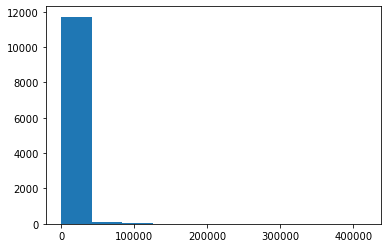

In [10]:
# Clear class imbalance
plt.hist(fire_final1['FinalAcres'],bins=10);#, bins=10, range=(0, 10));

# fire_final1.drop(columns='FinalAcres', inplace=True)

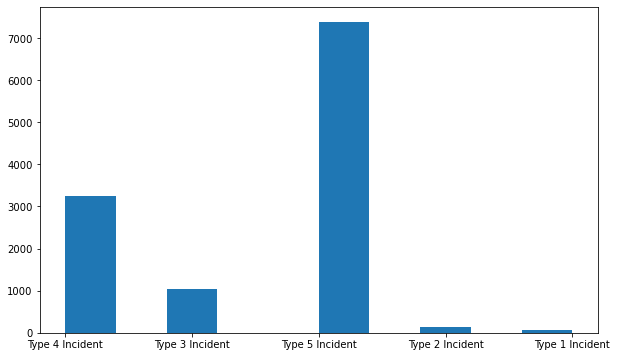

In [34]:
fig, ax = plt.subplots(figsize = (10,6))
if target == 'FireMgmtComplexity':
    plt.hist(fire_final1['FireMgmtComplexity'])
try:
    plt.hist(fire_final1['FinalAcresBin'])#, bins=10, range=(0, 10));
except Exception as e:
    e

In [ ]:
# List of functions
%whos function

<a id="modeling-class"></a>
# Modeling Class
[Go to Top](#top)

The Class below is used to create train test split, build pipeline, model, and evalaute

#### Pipeline
- one hot encoder for categoricals
- Standard Scaler for numerical features
- SMOTE is used to resolve the large class imbalance

In [2]:
class model():
    '''
    This class is used to create test, split, modeling, model validation, and grid searches
    '''
    def __init__(self, X, y, model=None, **kwargs):
        '''
        X : DataFrame with Target removed
        y : Series containing the Target
        Mdoel: if external model is used, already has random forest, decision trees, and logistic regression
        **kwargs for train test split, like train_size, or test_size
        This is for classification models
        '''
        self.model = model
        if not isinstance(y,pd.core.series.Series):
            return 'y must be a series, containing the target'
        if y.name in X.columns:
            return 'Target (y) must be removed from X'
        
        self.__y = y
        self.__X = X
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=42, **kwargs)
        
        if model:
            self.score = self.model.score(self.X_test, self.y_test)
            self.y_pred_train = self.model.predict(self.X_train)
            self.y_pred_test = self.model.predict(self.X_test)
        
    def models(self, mtype, test=None, **kwargs):
        '''
        Function runs model through pipeline, 
        Classification models only
        mtype options: 'rfc' = RandomForest, 'trees' = Decision tree, 'log' = Logistic regression
        **kwargs : For the models additional parameters
        verbose  = 0, auto set to 0
        '''
        # Numerics for scaling
        df_num = list(self.__X.select_dtypes(include='number').columns)
        # categoricals for one hot encoder
        df_cat = list(self.__X.select_dtypes(include='object').columns)
        
        # pipeline
        subpipe_num = Pipeline(steps=[('ss', StandardScaler())])

        subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

        subpipe_smote = Pipeline(steps=[('smote', SMOTE(random_state=42, n_jobs=-1))])

        smote = SMOTE(sampling_strategy='auto', random_state=42, n_jobs=-1)

        CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, df_num),
                                                 ('subpipe_cat', subpipe_cat, df_cat)],
                                   remainder='passthrough')
        self.CT= CT
        self.df_num = df_num
        self.df_cat = df_cat
        # Model types ---------------------------------------------------------------------
        # Random forest 
        if mtype == 'rfc': 

            self.model = ImPipeline(steps=[('ct', CT,), 
                                               ('smote', smote),
                                             ('rfc', RandomForestClassifier(random_state=42, 
                                                                            n_jobs= -1,
                                                                             **kwargs))])
            self.model.fit(self.X_train, self.y_train)
        # Logistic regression 
        if mtype == 'log':
            self.model = ImPipeline(steps=[('ct', CT),
                                      ('smote', smote), 
                                    ('logreg', LogisticRegression(random_state=42, max_iter=100,
                                                                  n_jobs=-1, **kwargs))])
                                    
            self.model.fit(self.X_train, self.y_train)
        # Decision trees
        if mtype == 'trees':
            self.model = Pipeline(steps=[('ct', CT), 
                                   ('dt', DecisionTreeClassifier(random_state=42, **kwargs))])
            self.model.fit(self.X_train, self.y_train)
        
        if mtype == 'svc':
            check = input("Are you sure you want to run this? It may take hours to complete.\nEnter 'yes' or 'no': ")
            if check == 'yes':
                self.model = ImPipeline(steps=[('ct', CT,), 
                                                   ('smote', smote),
                                                 ('svm', SVC(random_state=42, verbose=10))])

                self.model.fit(self.X_train, self.y_train)
            else:
                return 'Execution Stopped'

        # General return
        self.y_pred_test = self.model.predict(self.X_test)
        if test:
            self.score = self.model.score(self.X_test, self.y_test)
            return print(f'Test Score: {self.score}\nTrain Score: {self.model.score(self.X_train, self.y_train)}')
        else:
            return print(f"Train Score: {self.model.score(self.X_train,self.y_train)}")     
    def gridsearch(self, params_grid, **kwargs):
        '''
        **kwargs:
            estimator,
            param_grid,
            *,
            scoring=None,
            n_jobs=None,
            iid='deprecated',
            refit=True,
            cv=None,
            verbose=0,
            pre_dispatch='2*n_jobs',
            error_score=nan,
            return_train_score=False
            
            RandomForestClassifier options:
                    n_estimators=100,
                    criterion='gini',
                    max_depth=None,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    min_weight_fraction_leaf=0.0,
                    max_features='auto',
                    max_leaf_nodes=None,
                    min_impurity_decrease=0.0,
                    min_impurity_split=None,
                    bootstrap=True,
                    oob_score=False,
                    n_jobs=None,
                    random_state=None,
                    verbose=0,
                    warm_start=False,
                    class_weight=None,
                    ccp_alpha=0.0,
                    max_samples=None
        '''
        self.gsmodel = GridSearchCV(estimator=self.model,
                 param_grid= params_grid, n_jobs=-1, **kwargs)
    
        self.gsmodel.fit(X_train, y_train)
        return self.gsmodel.best_params_ , self.gsmodel.best_score_
    
    def scoringHelp(self):
        '''Scoring options, no inputs'''
        from sklearn.metrics import SCORERS
        print(f'List of Scoring options:{list(SCORERS.keys())}')
        
    def cross_validate(self, **kwargs):
        '''
        **kwargs:
                estimator,
                X,
                y=None,
                *,
                groups=None,
                scoring=None,
                cv=None,
                n_jobs=None,
                verbose=0,
                fit_params=None,
                pre_dispatch='2*n_jobs',
                error_score=nan
                
        For scoring run .scoringHelp to view options
        '''
        self.cvs_results = cross_val_score(X=self.X_train, y=self.y_train, estimator = self.model,
                                           **kwargs).mean() 
#         self.cv_results = cross_validate(X=self.X_train, y=self.y_train, estimator = self.model,
#                                          cv=cv_input,return_train_score=True).mean()
        print(f'CV Results: {self.cvs_results}')
    
    def test_report(self, Return=False, **kwargs):
        '''
        Returns claassiciation report for y_test and y_pred_test
        **kwargs for addtional arguments like output_dict=True if you want to save
        Saving: set Return = True
        '''
        if Return:
            return classification_report(self.y_test, self.y_pred_test, output_dict=True, **kwargs)
        else:
            print(classification_report(self.y_test, self.y_pred_test, **kwargs))
        
        
    def aprf(self, test=None, **kwargs):
        '''
        test : return test scores, if test = 'full' then predicts on X otherwise on X_test
        '''
        # Accuracy, Precision, Recall, and F1-Score
        if test == 'full':
            print('Predicting X, full dataset')
            y_pred_train = self.model.predict(self.X_train)
            y_pred_full = self.model.predict(self.__X)
        else:
            y_pred_train = self.model.predict(self.X_train)
            y_pred_test = self.model.predict(self.X_test)
            y_pred_full = None
        try:
            #accuracy
            self.train_accuracy = accuracy_score(self.y_train, y_pred_train)
            if test == 'full':
                self.test_accuracy = accuracy_score(self.__y, y_pred_full)
            else:
                self.test_accuracy = accuracy_score(self.y_test, y_pred_test)
            print(f'Training Accuracy: {self.train_accuracy}')
            if test:
                print(f'Testing Accuracy: {self.test_accuracy}')

            # Precision
            print(f'Training Precision: {precision_score(self.y_train, y_pred_train, **kwargs)}')
            if test:
                if test == 'full':
                    print(f'Testing Precision: {precision_score(self.__y, y_pred_full, **kwargs)}')
                else:
                    print(f'Testing Precision: {precision_score(self.y_test, y_pred_test, **kwargs)}')

            # Recall
            self.train_recall = recall_score(self.y_train, y_pred_train, **kwargs)
            if test == 'full':
                self.test_recall = recall_score(self.__y, y_pred_full, **kwargs)
            else:
                self.test_recall = recall_score(self.y_test, y_pred_test, **kwargs)
            print(f'Training Recall: {self.train_recall}')
            if test:
                print(f'Testing Recall: {self.test_recall}')

            # F1-Score
            self.train_f1 = f1_score(self.y_train, y_pred_train, **kwargs)
            if test == 'full':
                self.test_f1 = f1_score(self.__y, y_pred_full, **kwargs)
            else:
                self.test_f1 = f1_score(self.y_test, y_pred_test, **kwargs)
                
            print(f'Training F1-Score: {self.train_f1}')
            if test:
                print(f'Testing F1-Score: {self.test_f1}')
       
        except Exception as e:
            print("An error occurred:", e)

- [Go to Data Checkpoint 2](#Data-Checkpoint-2)

In [36]:
fire_final1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11866 entries, 2 to 122951
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   X                                  11866 non-null  float64
 1   Y                                  11866 non-null  float64
 2   OBJECTID                           11866 non-null  int64  
 3   FireMgmtComplexity                 11866 non-null  object 
 4   FinalAcres                         11866 non-null  float64
 5   DispatchCenterID                   11601 non-null  object 
 6   GACC                               11866 non-null  object 
 7   POOCounty                          11866 non-null  object 
 8   POOFips                            11866 non-null  object 
 9   POOJurisdictionalAgency            7731 non-null   object 
 10  POOJurisdictionalUnit              9501 non-null   object 
 11  POOState                           11866 non-null  ob

<a id="Elevation"></a>
# Elevation
[Go to Top](#top)

In [543]:
def elevation(row, counts=0):
    '''
    This function inputs a dataframe row,  takes X and Y and pulls elevation
    Required columns:
    X : Longitude 
    Y : Latitude 
    OBJECTID : objectid
    
    Notes:
    This is designed to run in with joblib, works best running ~ 2000 rows at a time, save and then repeat
    '''
    # URL for Open-Elevation API
    url = 'https://api.open-elevation.com/api/v1/lookup'

    # latitude and longitude values
    lat = row['Y']
    lon = row['X']
    obid = row['OBJECTID']

    # API request
    request_url = f'{url}?locations={lat},{lon}'

    # GET request
    response = requests.get(request_url)

    # Check if the request was successful, will try 15 times before returning null
    if response.status_code == 200:
        # Extract elevation from the response
        elevations = response.json()['results'][0]['elevation']
        return { obid: elevations}
        
    else: 
        exc = []
        def retry(counts):
            try: 
                elevations = response.json()['results'][0]['elevation']
                return {obid : elevations}
            except Exception as e:
                if counts <15:
                    counts+=1
                    return elevation(row,counts)
                else:
                    return {obid : np.nan}
                
        retried = retry(counts)
        return retried      

In [663]:
# Code to run elevation function in parallel with joblib
results_e = Parallel(n_jobs=-1, verbose=1)(
    delayed(elevation)(row) for index, row in fire_final1.iterrows())

st = time.time()
# create one dict, from the nest
result_dict = {key: value for r in results_e for key, value in r.items()}
print(f"Total Run Time: {time.time()- st}")

# take output dict and add to dataframe
st = time.time()
# Updating elevation column in fire_final1
fire_final1['elevation'] = fire_final1['OBJECTID'].map(result_dict).fillna(fire_final1['elevation'])
print(f"Total Run Time: {time.time()- st}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Total Run Time: 0.00015687942504882812
Total Run Time: 0.007983207702636719


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    3.8s finished


In [664]:
# Null index checker, use to check what rows needs to be run again
num = 11866
if len(np.where(fire_final1[0:num]['elevation'].isna())[0].tolist()) < 10:
    print(np.where(fire_final1[0:num]['elevation'].isna())[0].tolist())
    
print(fire_final1[0:num]['elevation'].isna().sum())
fire_final1[0:num][fire_final1[0:num]['elevation'].isna()]#.sum()


[]
0


,X,Y,OBJECTID,FireMgmtComplexity,DispatchCenterID,GACC,POOCounty,POOFips,POOJurisdictionalAgency,POOJurisdictionalUnit,POOState,site,total_solar_radiation_ly,ave_mean_wind_speed_mph,ave_mean_wind_direction_deg,max_maximum_wind_gust_mph,ave_average_air_temperature_deg_f,ave_average_relative_humidity,total_precipitation_in,elevation


In [1414]:
fire_final1

,X,Y,OBJECTID,FireMgmtComplexity,DispatchCenterID,GACC,POOCounty,POOFips,POOJurisdictionalAgency,POOJurisdictionalUnit,POOState,site,total_solar_radiation_ly,ave_mean_wind_speed_mph,ave_mean_wind_direction_deg,max_maximum_wind_gust_mph,ave_average_air_temperature_deg_f,ave_average_relative_humidity,total_precipitation_in,elevation
1817,-121.604615,47.638906,1818,Type 4 Incident,WAPSC,NWCC,King,53033,USFS,WAMSF,US-WA,3260924A,185.622642,2.549245,119.792453,15.160377,48.062264,75.698113,0.142642,888.0
13105,-117.058714,48.648346,13108,Type 4 Incident,IDCDC,NRCC,Pend Oreille,53051,USFS,IDIPF,US-WA,327416FA,269.712644,2.082011,273.568966,12.637931,45.938506,74.126437,0.047529,1184.0
52351,-122.050314,43.363345,52366,Type 3 Incident,ORRICC,NWCC,Douglas,41019,USFS,ORUPF,US-OR,3237F1DA,267.310160,3.176524,207.042781,15.534759,44.718717,70.732620,0.100588,1779.0
57692,-120.684915,47.963556,57710,Type 5 Incident,WACWC,NWCC,Chelan,53007,USFS,WAOWF,US-WA,323807CC,145.610526,1.598105,176.894737,13.410526,41.571579,75.063158,0.088526,1858.0
69603,-120.897615,47.882316,69625,Type 5 Incident,WACWC,NWCC,Chelan,53007,USFS,WAOWF,US-WA,323807CC,210.193548,1.776613,185.895161,14.032258,47.508871,69.895161,0.068629,840.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256442,-83.144794,37.232427,305668,Type 5 Incident,KYKIC,SACC,Perry,21193,DVF,KYKYS,US-KY,4030305E,402.666667,3.613333,147.000000,16.333333,58.100000,65.000000,0.046667,321.0
256452,-83.692464,36.744317,305681,Type 5 Incident,KYKIC,SACC,Bell,21013,DVF,KYKYS,US-KY,FA41A3DA,142.000000,1.880000,131.000000,16.000000,53.800000,84.000000,0.400000,316.0
256461,-83.666022,37.714499,305700,Type 5 Incident,KYKIC,SACC,Wolfe,21237,DVF,KYKYS,US-KY,3284A760,330.200000,6.834000,217.400000,24.800000,55.200000,74.000000,0.130000,314.0
256490,-83.160804,37.338307,305748,Type 5 Incident,KYKIC,SACC,Perry,21193,DVF,KYKYS,US-KY,4030305E,340.500000,3.980000,150.500000,17.000000,58.650000,76.000000,0.065000,362.0


In [667]:
# saving elevation dataset
fire_elevation = fire_final1[['OBJECTID','elevation']]
# fire_elevation.to_csv('fire_elevation.csv', index=False)

In [894]:
# saving final model data
# fire_final1.to_csv('fire_model_data.csv', index=False)

<a id='Data Checkpoint 2'></a>
# Data Checkpoint 2
[Go to Top](#top)


Run These Cells:
- [Modeling Class](#modeling-class)
- [Data Checkpoint](#Data-Checkpoint)


In [3]:
# Load fire_final2
fire_final2 = pd.read_csv('Data/fire_model_data.csv')
# fire_final2 = fire_final1.copy()


# Dropping columns deemed to be not useful
fire_final2.drop(columns=['X', 'Y', 'OBJECTID', 'GACC', 'POOCounty', 'POOFips', 'POOJurisdictionalUnit',
                          'POOState'], inplace=True)

In [4]:
# setting target and dropping finalacres if present
target2 = 'FireMgmtComplexity'

try:
    fire_final2.drop(columns=['FinalAcres'], inplace=True) 
except:
    pass

- Jurisdictional unit is at too micro of a level
- County, state, fips, and GACC are redundent metrics that lower the resolution of the model
<a id="model-class"></a>
# Instantiating Model class

In [5]:
# Creating model
fire_final2.dropna(inplace=True)
X = fire_final2.drop(columns= target2)
y = fire_final2[target2]

fire_model = model(X,y)

In [6]:
fire_final2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7731 entries, 0 to 11865
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   FireMgmtComplexity                 7731 non-null   object 
 1   DispatchCenterID                   7731 non-null   object 
 2   POOJurisdictionalAgency            7731 non-null   object 
 3   site                               7731 non-null   object 
 4   total_solar_radiation_ly           7731 non-null   float64
 5   ave_mean_wind_speed_mph            7731 non-null   float64
 6   ave_mean_wind_direction_deg        7731 non-null   float64
 7   max_maximum_wind_gust_mph          7731 non-null   float64
 8   ave_average_air_temperature_deg_f  7731 non-null   float64
 9   ave_average_relative_humidity      7731 non-null   float64
 10  total_precipitation_in             7731 non-null   float64
 11  elevation                          7731 non-null   floa

In [7]:
# saving x and y train and test
X_train, X_test, y_train, y_test = fire_model.X_train, fire_model.X_test, fire_model.y_train, fire_model.y_test
y_train.value_counts(normalize=1)

Type 5 Incident    0.674543
Type 4 Incident    0.240773
Type 3 Incident    0.071921
Type 2 Incident    0.008451
Type 1 Incident    0.004312
Name: FireMgmtComplexity, dtype: float64

In [8]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_train)

In [9]:
cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
cv_results.mean()

0.6745430067537412

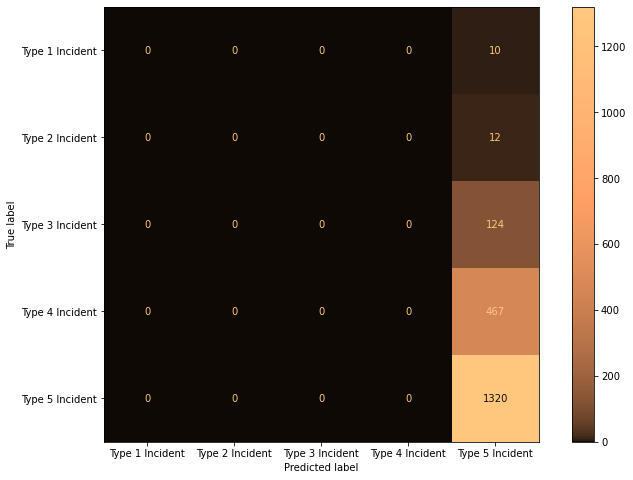

In [693]:
# copper
cmap = mpl.cm.copper
colors = cmap(np.linspace(.05, 1, cmap.N))

cmap_modified = mpl.colors.ListedColormap(colors)
gradient_cmap = mpl.colors.LinearSegmentedColormap.from_list('gradient_cmap', colors, gamma=.4)

fig, ax = plt.subplots(figsize=(12, 8))
plot_confusion_matrix(dummy_model, X_test, y_test, ax=ax, cmap=gradient_cmap);

In [36]:
baseline = model(X, y, dummy_model)
baseline.cross_validate()

CV Results: 0.6745430067537412


In [37]:
baseline.aprf(average='weighted')

Training Accuracy: 0.6745429458433942
Training Precision: 0.4550081857870843
Training Recall: 0.6745429458433942
Training F1-Score: 0.5434416440814739


/Users/keanan/opt/anaconda3/envs/flatiron-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a id="random-forest"></a>
# Random Forest 
[Go to Top](#top)

In [156]:
fire_model.models('rfc')

Train Score: 0.9996550534667127


In [157]:
# accuracy
fire_model.cross_validate(n_jobs=-1)

CV Results: 0.8104525304215882


In [1018]:
fire_model.scoringHelp()

List of Scoring options:['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted']


In [158]:
# Perform cross-validation with F1 score
fire_model.cross_validate(n_jobs=-1, scoring = 'f1_weighted') # f1_weighted recall_weighted

CV Results: 0.8075472717534069


In [159]:
# Recall
fire_model.cross_validate(n_jobs=-1, scoring = 'recall_weighted') # f1_weighted recall_weighted

CV Results: 0.8104525304215882


In [160]:
fire_model.aprf(average='weighted')

Training Accuracy: 0.9996550534667127
Training Precision: 0.9996566999895447
Training Recall: 0.9996550534667127
Training F1-Score: 0.9996554219713732


<a id="decision-tree"></a>
# Decision Tree

In [77]:
fire_model.models('trees')

Train Score: 0.9996765847347995


In [58]:
fire_model.cross_validate(n_jobs=-1,scoring = 'f1_weighted')

CV Results: 0.7650126935530464


In [59]:
fire_model.cross_validate(n_jobs=-1, scoring = 'recall_weighted')

CV Results: 0.7643925302106307


In [78]:
fire_model.aprf(average='weighted')

Training Accuracy: 0.9996765847347995
Training Precision: 0.9996780548041867
Training Recall: 0.9996765847347995
Training F1-Score: 0.9996769144217802


After runninig the models with the final set of data, Random Forest returned the best model, 
Both models fit well to the training data

<a id="grid-search"></a>
# Grid Search

In [79]:
fire_model.models('rfc')

Train Score: 0.9996765847347995


In [1046]:
params_grid = {"rfc__criterion": ["gini", "entropy"],
               "rfc__max_depth": [10, 20, 30, 40, 50],
               "rfc__min_samples_split": [2, 5, 10],
               "rfc__min_samples_leaf": [1, 5, 10, 15, 30, 50]
              }
fire_model.gridsearch(params_grid, scoring='f1_weighted', verbose=1)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 34.5min finished


({'rfc__criterion': 'entropy',
  'rfc__max_depth': 50,
  'rfc__min_samples_leaf': 1,
  'rfc__min_samples_split': 2},
 0.8091065271810889)

It appears that max depth value is likely higher, going to run another general grid search but expand the values for max depth and increase the resolution for the other parameters

In [1075]:
params_grid = {"rfc__n_estimators" :[50,100,150,200],
               "rfc__criterion": ["gini", "entropy"],
               "rfc__max_depth": [10, 40, 50, 60, 70, 80],
               "rfc__min_samples_split": [2, 3, 4],
               "rfc__min_samples_leaf": [1, 2, 3, 4, 5]
              }
fire_model.gridsearch(params_grid, scoring='f1_weighted', verbose=1)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 56.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 85.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 111.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 149.6min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 170.8min finished


({'rfc__criterion': 'entropy',
  'rfc__max_depth': 80,
  'rfc__min_samples_leaf': 1,
  'rfc__min_samples_split': 4,
  'rfc__n_estimators': 100},
 0.8122947935953431)

Max depth can still go higher, min sample leafs is likely 1 , and min samples split als seemed to have found sweet spot as 4

In [1077]:
# setting n estimators to default 100, setting min samples leaf to default of 1
params_grid = {"rfc__criterion": ["entropy"],
               "rfc__max_depth": [70, 80, 90, 100, 120, 140],
               "rfc__min_samples_split": [2, 3, 4, 5, 6, 7],
              }
fire_model.gridsearch(params_grid, scoring='f1_weighted', verbose=1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.3min finished


({'rfc__criterion': 'entropy',
  'rfc__max_depth': 120,
  'rfc__min_samples_split': 4},
 0.8123104803276566)

I think this grid search found the best parameters, i am going to run one more with higher resolution around ma depth = 120

In [1078]:
# last grid search increasing number of folds
params_grid = {"rfc__criterion": ["entropy"],
               "rfc__max_depth": [100, 110, 120, 130, 140],
               "rfc__min_samples_split" : [2, 3, 4, 5, 6, 7],
              }
fire_model.gridsearch(params_grid, scoring='f1_weighted', cv=10, verbose=1)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.0min finished


({'rfc__criterion': 'entropy',
  'rfc__max_depth': 110,
  'rfc__min_samples_split': 4},
 0.8122706666618329)

This grid search performed worse with 10 folds. Going to stick with the previous grid search and keep folds to 5

## Grid Search Evaluation
- The second to last grid search performed the best, with 5 folds. Overall each grid search got better and the parameters became more fine tuned
-----

## Best Parameters 
**That are not default values:**
- criterion = 'entropy',
- max_depth = 120,
- min_samples_split = 4,

---
<a id="final-model"></a>
# Final Model
[Go to Top](#top)

In [10]:
fire_model.models('rfc',
                  criterion= 'entropy',
                  max_depth= 120,
                  min_samples_split= 4, test=True)

Test Score: 0.8380755302638386
Train Score: 0.9932735426008968


In [106]:
# Model Tree
fire_model.model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['total_solar_radiation_ly',
                                                   'ave_mean_wind_speed_mph',
                                                   'ave_mean_wind_direction_deg',
                                                   'max_maximum_wind_gust_mph',
                                                   'ave_average_air_temperature_deg_f',
                                                   'ave_average_relative_humidity',
                                                   'total_precipitation_in',
                                                   'elevation']),
                                                 ('subpip

In [464]:
fire_model.test_report()


                 precision    recall  f1-score   support

Type 1 Incident       0.75      0.60      0.67        10
Type 2 Incident       0.11      0.08      0.10        12
Type 3 Incident       0.39      0.25      0.30       124
Type 4 Incident       0.65      0.81      0.72       467
Type 5 Incident       0.96      0.91      0.94      1320

       accuracy                           0.84      1933
      macro avg       0.57      0.53      0.54      1933
   weighted avg       0.84      0.84      0.84      1933



In [163]:
fire_model.cross_validate(n_jobs=-1, scoring = 'f1_weighted') # f1_weighted recall_weighted

CV Results: 0.8123104803276566


In [489]:
fire_model.aprf(test=True, average='weighted')

Training Accuracy: 0.9932735426008968
Testing Accuracy: 0.8380755302638386
Training Precision: 0.9932782416512479
Testing Precision: 0.8430048946512145
Training Recall: 0.9932735426008968
Testing Recall: 0.8380755302638386
Training F1-Score: 0.9932738139763453
Testing F1-Score: 0.8367573570291799


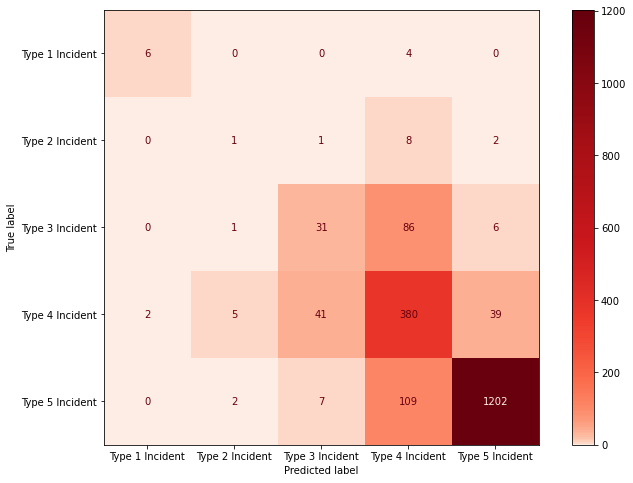

In [34]:
# copper
cmap = mpl.cm.Reds
colors = cmap(np.linspace(.05, 1, cmap.N))

cmap_modified = mpl.colors.ListedColormap(colors)
gradient_cmap = mpl.colors.LinearSegmentedColormap.from_list('gradient_cmap', colors, gamma=.4)

fig, ax = plt.subplots(figsize=(12, 8))
plot_confusion_matrix(fire_model.model, fire_model.X_test, fire_model.y_test, ax=ax, cmap=gradient_cmap);

# plt.gcf().set_facecolor('white')
# plt.savefig('white_images/matrix_red_w.png', dpi=100)

The model is able to predict majority of each type accuraatly except for type 2 incidents. 
This could be due to the fact that type 2 incidents appear to be a stepping stone or place holder level before moving up to type 5.

<a id="model-evalutation"></a>
# Model Evaluation

In [487]:
fire_model.aprf(test='full', average='weighted')

Predicting X, full dataset
Training Accuracy: 0.9932735426008968
Testing Accuracy: 0.954469020825249
Training Precision: 0.9932782416512479
Testing Precision: 0.9554598028141272
Training Recall: 0.9932735426008968
Testing Recall: 0.954469020825249
Training F1-Score: 0.9932738139763453
Testing F1-Score: 0.9545859912049014


The above evaluation on the entire dataset is eexpected to run better due to it already seeing 70% of the data.
The confusion matrix from the test data shows fairly high accuracy. For type 1 incidents it predicted 60% incidents correctly while the other 40% where predicted to be type 4 incidents. This is likley due to missing information such as remoteness or fire incidents location to populated areas, drought data, and other meterics that had to bbe droped such as acres or the ecconomic costs.
Continuing with the testing evalutation, the model has a 81.2% cross validation score compared to the first model of 80% so after the grid searach we have a slight inmprovment. Type 5 incidents have the highest f1 score at 94%, type 4 at 72%, type 3 at 30%, type 2 at 10% and finally type 1 incidents at 67%. 

<a id="interpreting-results"></a>
# Interpreting Results

In [16]:
# Pulling transformed categorical features
tf_names = fire_model.CT.named_transformers_['subpipe_cat']['ohe'].get_feature_names().tolist()

# Creating full list of features
features_t = fire_model.df_num.copy()
features_t.extend(tf_names)

In [17]:
# creating important features
important_featured = {name: score 
                       for name, score 
                          in zip(features_t, fire_model.model['rfc'].feature_importances_)}
#                            in zip(X_train.columns, rfc_model_final['rfc'].feature_importances_)}

# Sorting list of important features
sorted_if = sorted(important_featured.items(), key= lambda x: x[1], reverse = True)

# Top 15 Important Features
im_df = pd.DataFrame(sorted_if[:15], columns=['Feature Name','Feature Importance'])

In [18]:
# Get the OneHotEncoder from the pipeline
one_hot_encoder = fire_model.model.named_steps['ct'].named_transformers_['subpipe_cat'].named_steps['ohe']

# Get the original feature names
original_feature_names = one_hot_encoder.get_feature_names(input_features=fire_model.df_cat)

# Create a dictionary to map one-hot encoded names to original names
feature_mapping = {feature_encoded: feature_original for feature_encoded, 
                   feature_original in zip(one_hot_encoder.get_feature_names(), original_feature_names)}


# Map the one-hot encoded names in 'im_df' to original names dictionary 
im_df['Original Name'] = im_df['Feature Name'].map(feature_mapping)

# if original name is nan then use Feature name
im_df['Original Name'].fillna(im_df['Feature Name'], inplace=True)


In [19]:
im_df['Original Name'].values

array(['elevation', 'DispatchCenterID_TXTIC', 'total_precipitation_in',
       'ave_mean_wind_speed_mph', 'ave_average_relative_humidity',
       'ave_mean_wind_direction_deg', 'total_solar_radiation_ly',
       'max_maximum_wind_gust_mph', 'ave_average_air_temperature_deg_f',
       'POOJurisdictionalAgency_SFS', 'POOJurisdictionalAgency_FS',
       'POOJurisdictionalAgency_BLM', 'site_324BD306',
       'POOJurisdictionalAgency_State', 'site_FA66D690'], dtype=object)

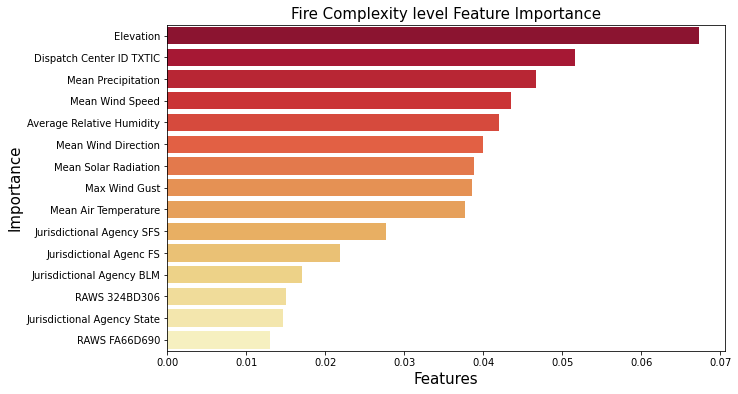

In [33]:
# Ploting Feature Importance
# import branca.colormap as cm
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.barplot(x=im_df['Feature Importance'], y=im_df['Original Name'], palette= 'YlOrRd_r')
ax.set_title('Fire Complexity level Feature Importance', fontsize=15)
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Importance', fontsize=15);

# Changing Feature names

new_names = ['Elevation', 'Dispatch Center ID TXTIC', 'Mean Precipitation',
       'Mean Wind Speed', 'Average Relative Humidity',
       'Mean Wind Direction', 'Mean Solar Radiation',
       'Max Wind Gust', 'Mean Air Temperature',
       'Jurisdictional Agency SFS', 'Jurisdictional Agenc FS',
       'Jurisdictional Agency BLM', 'RAWS 324BD306',
       'Jurisdictional Agency State', 'RAWS FA66D690']


ax.set_yticklabels(new_names);
# for changing background to white
# plt.gcf().set_facecolor('white')

# fig.savefig('white_images/feature_importance.png', dpi=100, bbox_inches='tight')


Training Accuracy: 0.9932735426008968
Testing Accuracy: 0.8380755302638386
Training Precision: 0.9932782416512479
Testing Precision: 0.8430048946512145
Training Recall: 0.9932735426008968
Testing Recall: 0.8380755302638386
Training F1-Score: 0.9932738139763453
Testing F1-Score: 0.8367573570291799


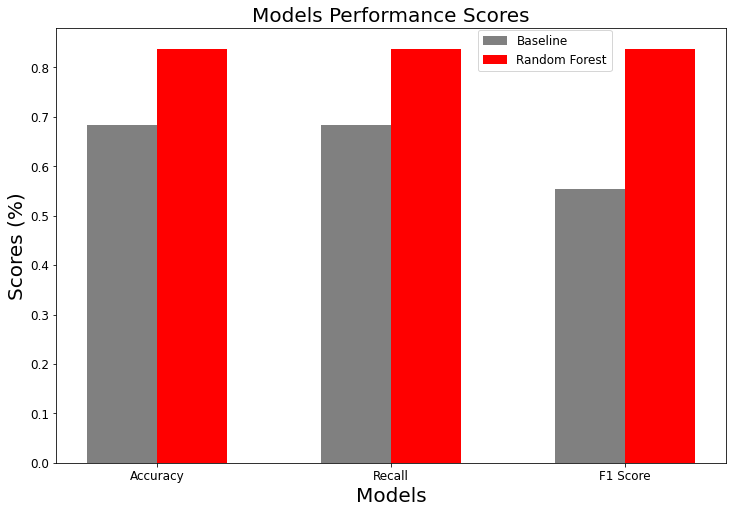

In [38]:
fig, ax = plt.subplots(figsize= (12,8))

fire_model.aprf(test=True, average='weighted')

width = .3

f1 = np.arange(3) 
f2 = [x + width for x in f1]

ax.bar(f1, [baseline.test_recall, baseline.test_accuracy, baseline.test_f1], width, label='Baseline', color='grey')

ax.bar(f2, [fire_model.test_recall, fire_model.test_accuracy, fire_model.test_f1], 
       width, label='Random Forest', color='red')





# Add labels and title
ax.set_xlabel('Models',fontsize=20)
ax.set_ylabel('Scores (%)',fontsize=20)
ax.set_title('Models Performance Scores',fontsize=20)

ax.set_xticks(f1 + width/2)
ax.set_xticklabels(['Accuracy', 'Recall','F1 Score'])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12,loc=(.63,.9));

# plt.gcf().set_facecolor('white')
# plt.savefig('white_images/scores.png', dpi=100, bbox_inches='tight')

In [465]:
final_scores = fire_model.test_report(Return=True)
final_scores

{'Type 1 Incident': {'precision': 0.75,
  'recall': 0.6,
  'f1-score': 0.6666666666666665,
  'support': 10},
 'Type 2 Incident': {'precision': 0.1111111111111111,
  'recall': 0.08333333333333333,
  'f1-score': 0.09523809523809525,
  'support': 12},
 'Type 3 Incident': {'precision': 0.3875,
  'recall': 0.25,
  'f1-score': 0.303921568627451,
  'support': 124},
 'Type 4 Incident': {'precision': 0.6473594548551959,
  'recall': 0.8137044967880086,
  'f1-score': 0.7210626185958254,
  'support': 467},
 'Type 5 Incident': {'precision': 0.9623698959167334,
  'recall': 0.9106060606060606,
  'f1-score': 0.9357726741922927,
  'support': 1320},
 'accuracy': 0.8380755302638386,
 'macro avg': {'precision': 0.5716680923766081,
  'recall': 0.5315287781454805,
  'f1-score': 0.5445323246640662,
  'support': 1933},
 'weighted avg': {'precision': 0.8430048946512145,
  'recall': 0.8380755302638386,
  'f1-score': 0.8367573570291799,
  'support': 1933}}

In [468]:
final_scores['Type 1 Incident']#['precision']

0.75

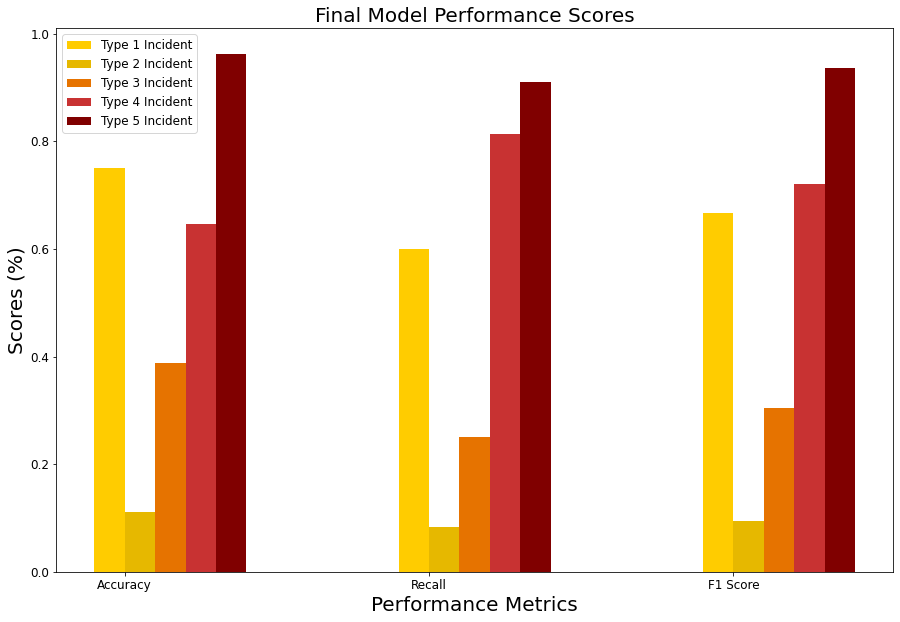

In [39]:
fig, ax = plt.subplots(figsize= (15,10))

final_scores = fire_model.test_report(Return=True)
metrics = ['precision', 'recall', 'f1-score', 'support']
labels = ['Type 1 Incident', 'Type 2 Incident', 'Type 3 Incident', 'Type 4 Incident', 'Type 5 Incident']

width = .1

f1 = np.arange(3) 
f2 = [x + width for x in f1]
f3 = [x + width for x in f2]
f4 = [x + width for x in f3]
f5 = [x + width for x in f4]

type1 = final_scores['Type 1 Incident']
type2 = final_scores['Type 2 Incident']
type3 = final_scores['Type 3 Incident']
type4 = final_scores['Type 4 Incident']
type5 = final_scores['Type 5 Incident']




    
# ax.bar(f1, [type1['precision'], type1['recall'], 
#             type1['f1-score']], width, label='Type 1 Incident', color='#D3D3D3')

# ax.bar(f2, [type2['precision'], type2['recall'], 
#             type2['f1-score']], width, label='Type 2 Incident', color='grey')

# ax.bar(f3, [type3['precision'], type3['recall'], 
#             type3['f1-score']], width, label='Type 3 Incident', color='black')

# ax.bar(f4, [type4['precision'], type4['recall'], 
#             type4['f1-score']], width, label='Type 4 Incident', color='#800000')

# ax.bar(f5, [type5['precision'], type5['recall'], 
#             type5['f1-score']], width, label='Type 5 Incident', color='#C83232')

ax.bar(f1, [type1['precision'], type1['recall'], 
            type1['f1-score']], width, label='Type 1 Incident', color='#FFCC00')

ax.bar(f2, [type2['precision'], type2['recall'], 
            type2['f1-score']], width, label='Type 2 Incident', color='#E6B800')

ax.bar(f3, [type3['precision'], type3['recall'], 
            type3['f1-score']], width, label='Type 3 Incident', color='#E67300')

ax.bar(f4, [type4['precision'], type4['recall'], 
            type4['f1-score']], width, label='Type 4 Incident', color='#C83232')

ax.bar(f5, [type5['precision'], type5['recall'], 
            type5['f1-score']], width, label='Type 5 Incident', color='#800000')

# Add labels and title
ax.set_xlabel('Performance Metrics',fontsize=20)
ax.set_ylabel('Scores (%)',fontsize=20)
ax.set_title('Final Model Performance Scores',fontsize=20)

ax.set_xticks(f1 + width/2)
ax.set_xticklabels(['Accuracy', 'Recall','F1 Score'])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12,loc='best');

# # color set to white for presentation plot
# ax.set_xlabel('Performance Metrics', fontsize=20, color='white')
# ax.set_ylabel('Scores (%)', fontsize=20, color='white')
# ax.set_title('Final Model Performance Scores', fontsize=20, color='white')

# ax.set_xticks(f1 + width/2)
# ax.set_xticklabels(['Accuracy', 'Recall', 'F1 Score'], color='white')
# ax.tick_params(axis='both', which='major', labelsize=12, colors='white')
# ax.legend(fontsize=12, loc='best')

# plt.gcf().set_facecolor('white')
# plt.savefig('white_images/Incident_scores.png', dpi=100, bbox_inches='tight')

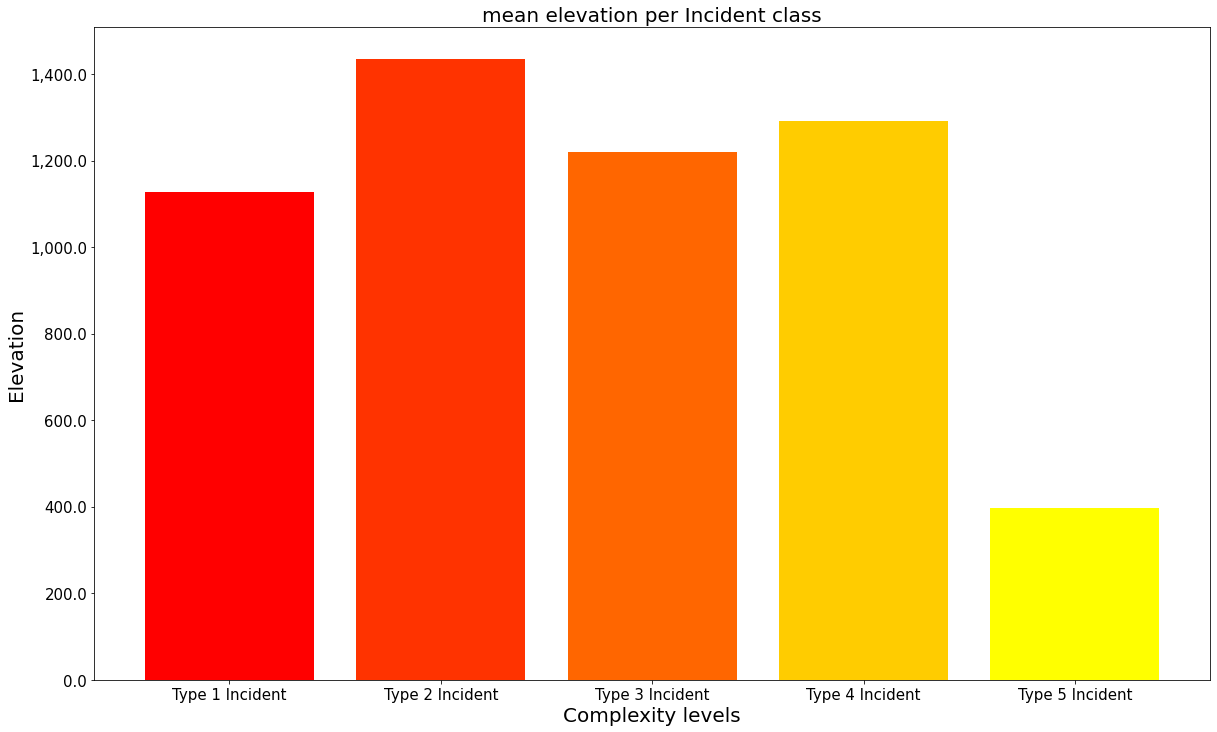

In [40]:
from matplotlib.ticker import StrMethodFormatter
def bar_plot(dfs, column, ylabel, aggregates, save_name=None):
    '''
    Bar plot function for evalutating how different features compare to the target
    dfs : dataframe
    column : column to compare to target
    ylabel : set y label
    aggregates : mean, sum, or max
    '''
    df = dfs.copy()
    fig, ax = plt.subplots(figsize=(20,12))
    df.sort_values(by=column, inplace=True)
    df.dropna(subset=['FireMgmtComplexity', column], inplace=True)
#     colors = ['grey']*3+['red']*1
    
    if aggregates == 'mean':
        mean_values = df.groupby('FireMgmtComplexity')[column].mean()
        try:
            mean_values = mean_values.drop('Type 1 Prescribed Fire')
        except:
            pass

        colors = ['yellow', '#FFCC00', '#FF6600', '#FF3300', 'red'][::-1]
        
    if aggregates == 'sum':
        aggregates = 'Total'
        mean_values = df.groupby('FireMgmtComplexity')[column].sum()
        try:
            mean_values = mean_values.drop('Type 1 Prescribed Fire')
        except:
            pass
        colors = ['red' if idx == mean_values.idxmax() else 'grey' for idx in mean_values.index]
        
    if aggregates == 'max':
        aggregates = 'Max'
        mean_values = df.groupby('FireMgmtComplexity')[column].max()
        try:
            mean_values = mean_values.drop('Type 1 Prescribed Fire')
        except:
            pass
        colors = ['red' if idx == mean_values.idxmax() else 'grey' for idx in mean_values.index]

    ax.bar(mean_values.index, mean_values.values, color=colors)
    
    ax.set_xlabel('Complexity levels',fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_title(f'{aggregates} {column} per Incident class', fontsize=20)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
    ax.tick_params(axis='both', which='major', labelsize=15);
    if save_name:
        plt.gcf().set_facecolor('white')
        plt.savefig(save_name,dpi=300)

bar_plot(fire_final2, fire_final2['elevation'].name, 'Elevation','mean')

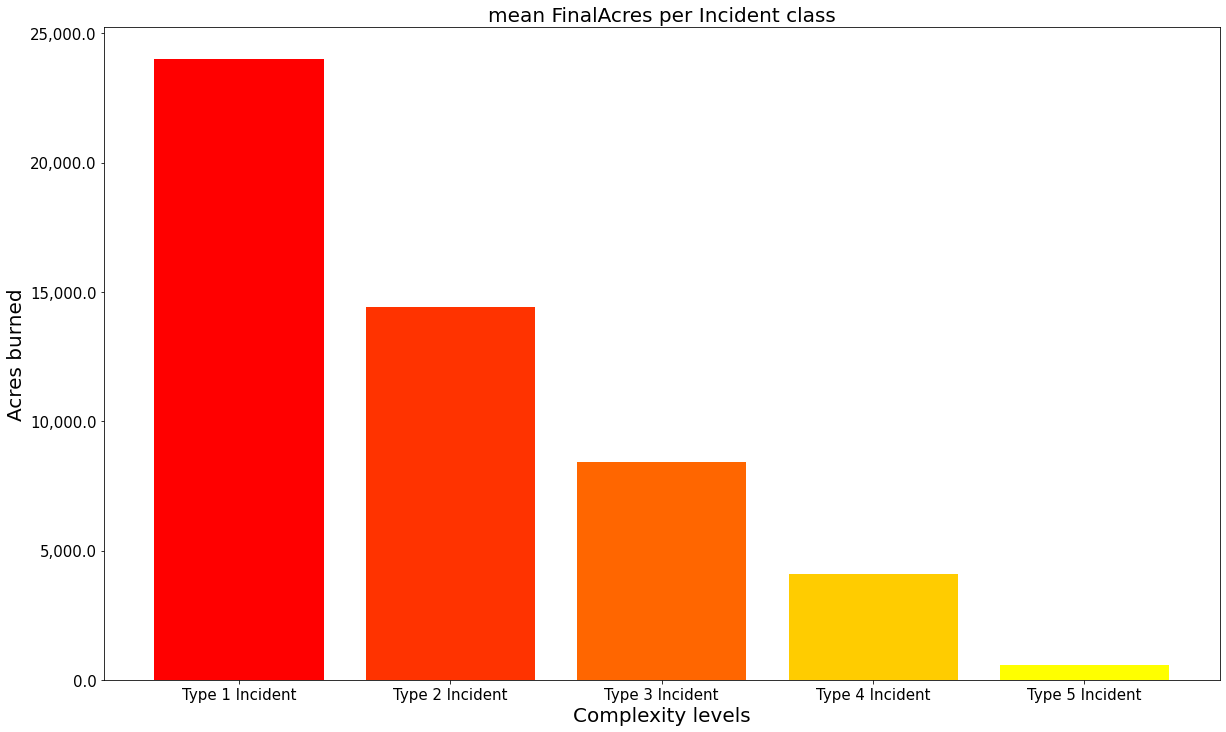

In [43]:
bar_plot(fire_final, 'FinalAcres', 'Acres burned','mean')

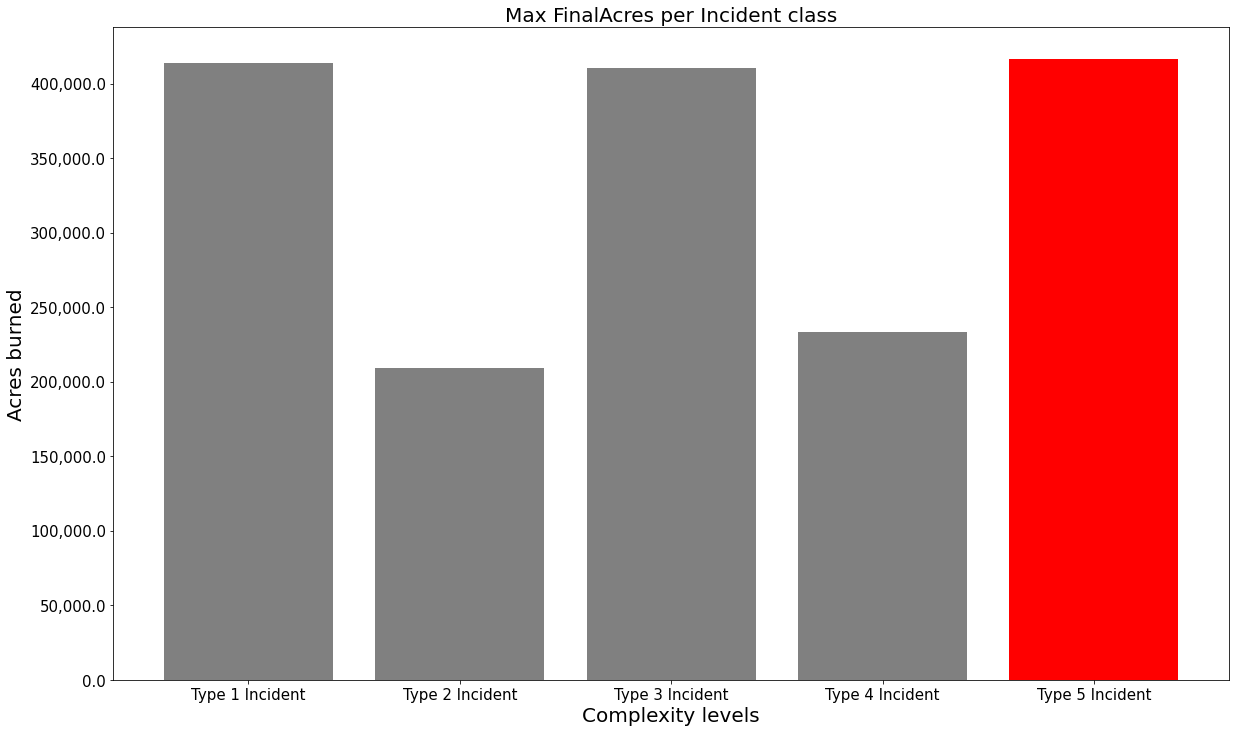

In [44]:
bar_plot(fire_final, 'FinalAcres', 'Acres burned','max')

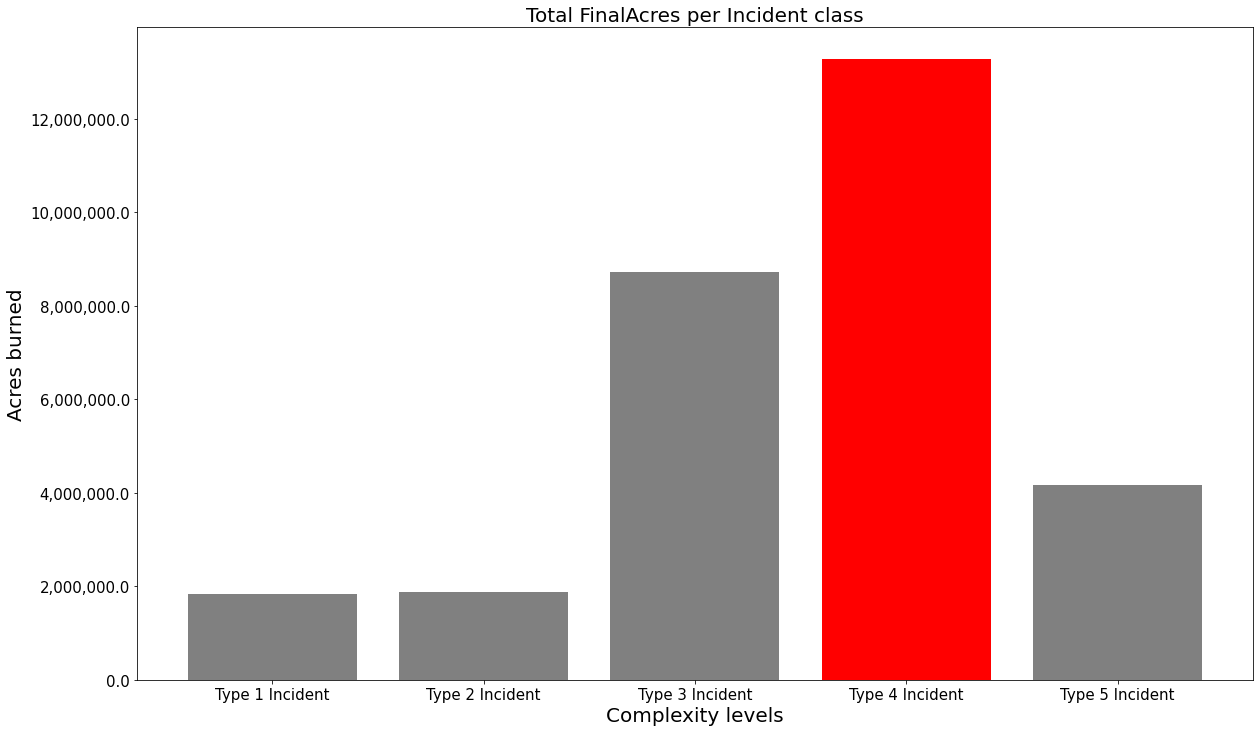

In [45]:
bar_plot(fire_final, 'FinalAcres', 'Acres burned','sum')

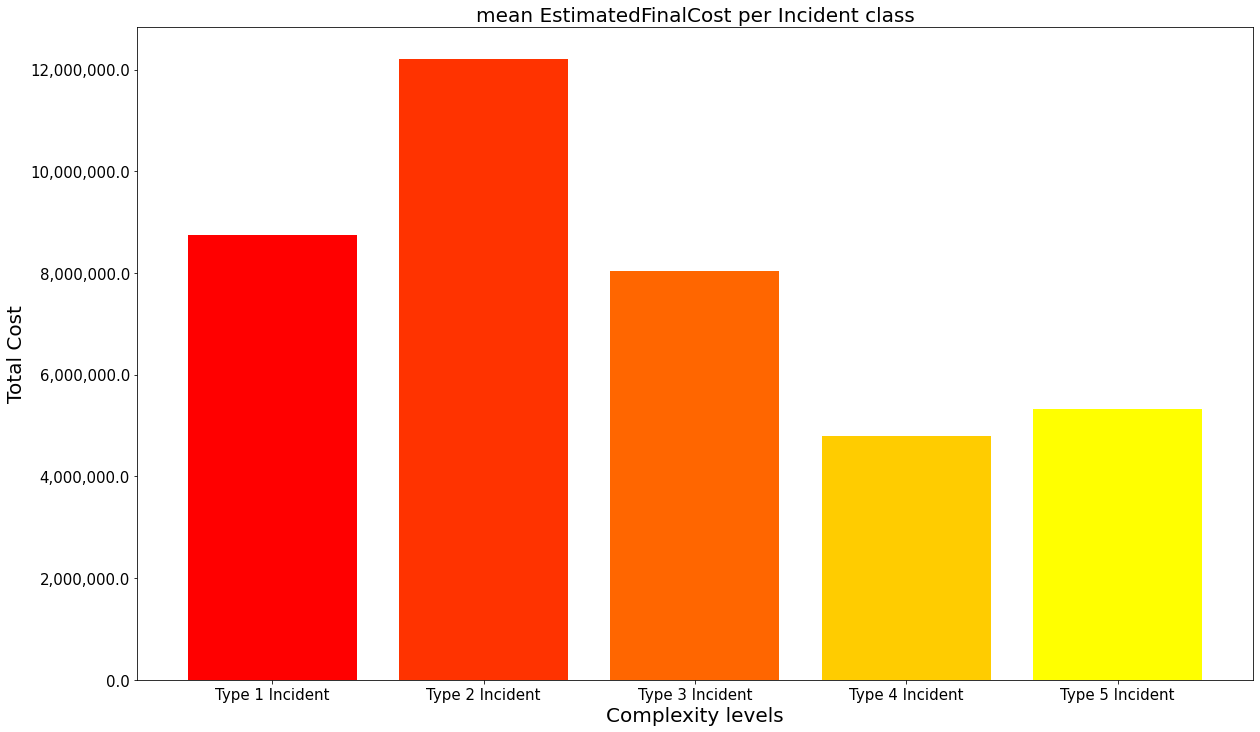

In [46]:
bar_plot(fire_final, fire_final['EstimatedFinalCost'].name, 'Total Cost','mean')

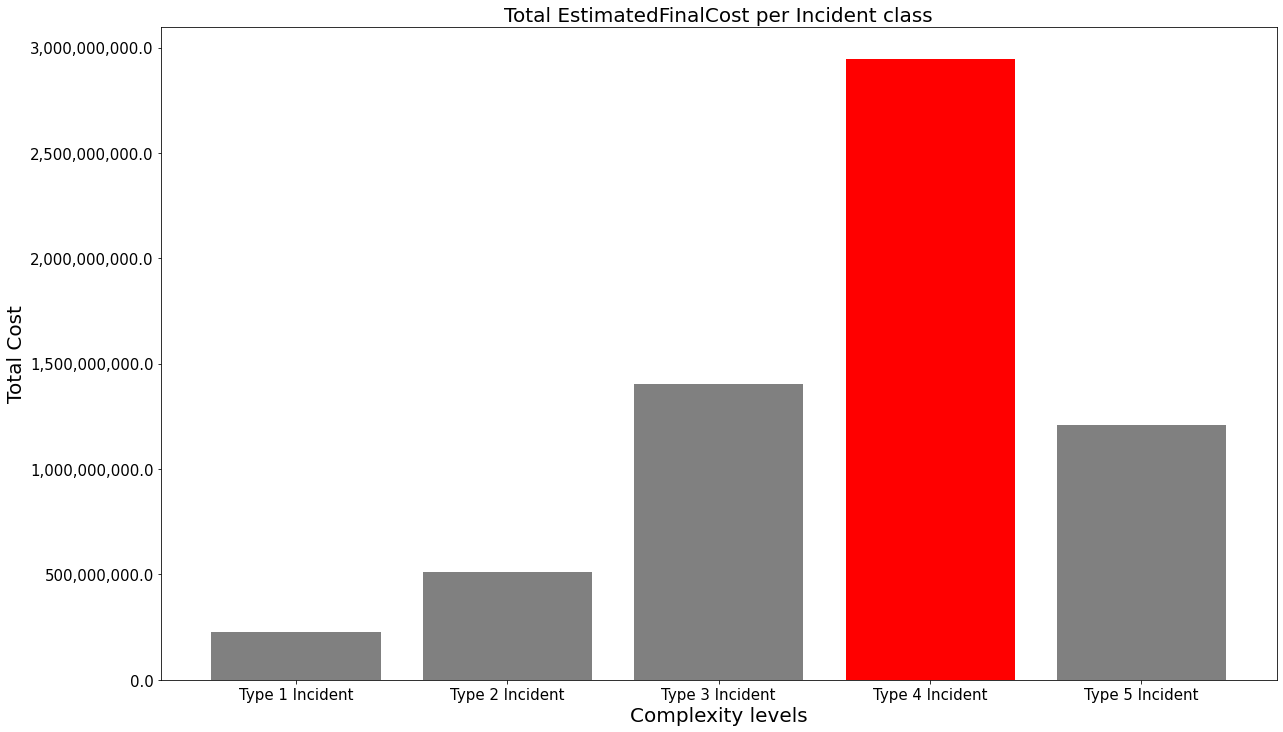

In [48]:
bar_plot(fire_final, fire_final['EstimatedFinalCost'].name, 'Total Cost','sum')

<a id="Conclusion"></a>
# Conclusion
[Go to Top](#top)

### The final model scores: 
| Complexity level | precision | recall | f1-score | support |
|----------------|-----------|--------|----------|---------|
| Type 1 Incident |   0.75    |  0.60  |   0.67   |    10   |
| Type 2 Incident |   0.11    |  0.08  |   0.10   |    12   |
| Type 3 Incident |   0.39    |  0.25  |   0.30   |   124   |
| Type 4 Incident |   0.65    |  0.81  |   0.72   |   467   |
| Type 5 Incident |   0.96    |  0.91  |   0.94   |   1320  |
| accuracy       |           |        |   0.84   |   1933  |
| macro avg      |   0.57    |  0.53  |   0.54   |   1933  |
| weighted avg   |   0.84    |  0.84  |   0.84   |   1933  |

<br>


<br>
The final model performs best at predicting type 5 incidents, even though I used smote, the majority of wildfires occur at the type 5 incident. This means that most fires are put out within a few days and or only require a few firefighters.
Type 4 incident is one level up and type 1 incidents have the next best performance. With type 2 and 3 performing poorly. Looking at the usability of this model it is more significant to be able to predict both extremes well. 
If a fire incident is 1 day old it is likely still at type 5, this model will be able to use current and forecasted meteorological data, and bureaucratic features such as agency and dispatch center to predict the fire incidents fire complexity level. Further evaluation shows that the highest mean acres burned and economic cost correlate with type 1 incidents, This for one confirms that fire complexity levels do correlate with fire scale and impact. However, this is not absolute, when evaluating the max acres burned for each level types 1, 3, and 5 all share close max acres burned. This could be an error in the data or Possibly more underlying factors influencing the fire complexity level. One speculation is that large fires occurring in heavily remote regions are less of a risk to people and communities. Further analysis also shows that type 4 incidents have the largest cumulative acres burned and economic costs. This is likely due to just the class imbalance as the mean shows that type 1 incidents are significantly higher in both features.

<a id="next-steps"></a>
# Next Steps

Looking at the next steps, I am looking to further improve model performance by adding additional features such as calculating drought data, remoteness index, and improving RAWS site selection. After this, I am looking to build a streamlit deployment of the model. This will involve setting up APIs and pulling current RAWS data, and potentially forecasted Meteorological data.